# Triangle Sud - Locie - 2021 

## Context and General Information

Authoring et logo laboratoire

### Related research work and article references

Rajouter les liens vers les travaux/articles reliés au projet Beaulac.

### Tool Information

*This notebook has been developed with OMEGAlpes version 0.4.3. It is shared with the licence [Apache 2.0](https://www.apache.org/licenses/LICENSE-2.0.html), Copyright 2018 G2Elab / MAGE*

### Binder link

>***First time using a Jupyter Notebook ?*** In order to use this notebook online through the Mybinder public service, please apply the following instructions: 

1. CLick on the binder button
   [![Binder](https://static.mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgricad-gitlab.univ-grenoble-alpes.fr%2Fomegalpes%2Fomegalpes_examples/master)
2. Follow the notebooks folder 
3. Chosse the article_2021_MDPI_waste_heat_V2 notebook

>You can then easily use this Jupyter notebook by runnning each cell with the Run ("Exécuter" in French) icon in the toolbar on top of the page. When the orange notebook icon in the tab turns into an hourglass, this means the code is still running. Do not hesitate to modify and adapt the code, working with Mybinder creates an online copy of the repository ipynb original file.

### Introduction and General description of the use case

The research project is led by the LOCIE laboratory. The main case study consists of studying the possibility of limiting the consumption of fossil energy in a district located near the Lac du Bourget, by using the lake's water. The aim is to connect the companies in the technology park and the nearby residential buildings to the lake via an open-circuit thermal network to ensure the heating and cooling of these buildings. 

In this context, the case study will focus on the sizing and choice of spatial distribution of small heat pumps (PAC) connected to this future water network, in order to heat the buildings served (temperature recovery by PAC). The use of local photovoltaic electrical energy production to power the heat pumps and the installation of local thermal storage will also be studied. 

#### Use Case
***Important note***: the article linked to this notebook is currently in the reviewing process. The OMEGAlpes version 0.4.1. will be released soon. As a result: this notebook can be used in order to observe and understand OMEGAlpes modelling principles, but it cannot be run online at the moment since it needs OMEGAlpes version 0.4.1. to be released. The use case source code is available in OMEGAlpes examples gitlab, and the 0.4.1. OMEGAlpes code is available on OMEGAlpes Gitlab.  

#### FactSheet link


#### Package requirement specifications

The first importation concerns the generic packages to import in order to correctly use OMEGAlpes (pulp or time) .

In [1]:
# Import package

%matplotlib notebook
%matplotlib notebook

from pulp import LpStatus
import time as timer
import os


Then the following script allow to load the correct version of Omegalpes that would be used in the following notebook

In [2]:
work_path = os.getcwd()

# Module version
__version_info__ = (0, 4, 1)
__version__ = ".".join(str(x) for x in __version_info__)

# Documentation strings format
__docformat__ = "restructuredtext en"

# Install corresponding omegalpes version
os.system('pip install omegalpes==' + __version__)

# Module version
__version_info__ = (2, 1, 0)
__version__ = ".".join(str(x) for x in __version_info__)

# Documentation strings format
__docformat__ = "restructuredtext en"

# Install corresponding omegalpes version
os.system('pip install pulp==' + __version__)

import pulp
print(pulp.__version__)

2.1


## Data specifications

Data profiles
    - license / open
    - source
    - ....

Data management

Data profile corresponding to the time step (1 hour) and duration 7 days)

## Table of contents

* [Model, Context and Solving](#chapter1)
    * [General Description](#chapter11)
    * [Schema of the use case](#chapter12)
    * [Optimization process](#chapter13)
        * [Assumptions](#chapter131)
        * [Model equations](#chapter132)
        * [Input parameter](#chapter133)
            * [Scalar parameter and design parameters](#chapter1331)
            * [Load and solar profiles](#chapter1332)
    * [Modelling process and solving](#chapter14)
        * [Power flow schema of the use case](#chapter141)
        * [Instanciation of the energy model](#chapter142)
        * [Solving process](#chapter143)
            * [Load energy nodes](#chapter1431)
            * [Integrate objective functions](#chapter1432)
            * [Solving the optimization problem](#chapter1433)
    * [Output assessments](#chapter15)
        * [Scalar outputs](#chapter151)
        * [Plotting energy flow and profiles](#chapter152)
* [Exergy model and Solving](#chapter2)
    * [Importing energy models](#chapter21)
    * [Importing and set exergy models](#chapter22)
    * [Apply specific exergy objective function](#chapter23)
    * [Solving process](#chapter24)
    * [Output assessments](#chapter25)
        * [Energy scalar outputs](#chapter251)
        * [Exergy scalar outputs](#chapter252)
        * [Plotting energy flow and profiles](#chapter253)
* [Change the design parameters of thermal and electric solar production and storage](#chapter3)
    * [Load a CSV file](#chapter31)
    * [Loop design](#chapter32)
    * [Save the CVS file](#chapter33)
* [General conclusion](#chapter4)

## Model, Context and Solving <a class="anchor" id="chapter1"></a>

### General Description <a class="anchor" id="chapter11"></a>

In this project they are 4 different energy vectors:

* electricity
* three kinds of thermal energy at different temperature

In terms of the energy systems present, at the electrical level, outside the grid, there is production with photovoltaic panels and storage with a battery pack. 

At the thermal level, the production of heat and domestic hot water is ensured by means of thermal solar panels and heat pumps coupled with thermal storage.

All the solar production and storage systems are elements to be dimensioned in this case study.

### Schema of the use case <a class="anchor" id="chapter12"></a>

The figure below shows the waste heat recovery use case and power flow at the district scale.

![Beaulac use case scheme](https://gricad-gitlab.univ-grenoble-alpes.fr/omegalpes/omegalpes_examples/-/raw/master/notebooks/figures/beaulac_schema_general.PNG)

### Optimization process  <a class="anchor" id="chapter13"></a>

#### Assumptions <a class="anchor" id="chapter131"></a>

In order to facilitate the energy modelling of the case study, the following simplifying assumptions were used:

* All temperature levels remain constant throughout the year.
* The efficiencies of all units remain constant.
* Pressure and heat losses in the pipes are neglected.
* Perfect temperature stratification is assumed within the thermal storage unit (thermocline type).
* The initial and final states of charge of the storage units (thermal and electrical) are identical.
* Heat losses within the thermal storage are taken into account, as well as the progressive self-discharge of the electric batteries.


#### Model equations  <a class="anchor" id="chapter132"></a>

Considering all energy units, we offer  a set of non-stationary energy balances for each unit. For each unit, the balance considers the inlet (Q<sup>in</sup>) and outlet (Q<sup>out</sup>) heat flows, the incoming (W<sup>in</sup>) and outgoing (W<sup>out</sup>) power and the energy storage (ΔU). The table below provides all these energy balance equations as well as additional equations for each energy unit.

![eq_model](https://gricad-gitlab.univ-grenoble-alpes.fr/omegalpes/omegalpes_examples/-/raw/master/notebooks/figures/equation_energy_beaulac.png)

#### Input parameter  <a class="anchor" id="chapter133"></a>

##### Scalar parameter and design parameters <a class="anchor" id="chapter1331"></a>

Before discussing about the energy models that represents the Beaulac project, the input parameter of the model are presented in this section.

First the focus is on the design parameters related to the solar collectors, the pv panels and the thermal and electrical storages.

The thermal parameter of the solar collector are initialized as follow, and would be change in the next part of the notebook.

In [3]:
ST_COLLECTORS_AREA = 507  # m²
ST_COLLECTORS_EFF = 0.80  # kW of heat / kW of solar irradiation
ST_COLLECTORS_OUTLET_TEMPERATURE = 65  # °C

Then the photovoltaïc production size is initialized

In [4]:
PV_PANELS_AREA = 42307  # m²
PV_PANELS_EFF = 0.15  # kW of electricity / kW of solar irradiation

Here the electrical storage data are initialized

In [5]:
ELEC_BATT_CAPA = 15000  # kWh (Capacity of electric batteries)
ELEC_BATT_MAX_CHARGE_POWER = 0.50 * ELEC_BATT_CAPA  # kW
ELEC_BATT_MAX_DISCHARGE_POWER = 0.50 * ELEC_BATT_CAPA  # kW
ELEC_BATT_SOC_MIN = 0.30  # % of maximal capacity
ELEC_BATT_SOC_MAX = 1.00  # % of maximal capacity
ELEC_BATT_SOC_INI = (0.5 * ELEC_BATT_SOC_MIN + 0.5 * ELEC_BATT_SOC_MAX) * ELEC_BATT_CAPA  # kWh
ELEC_BATT_SELF_DISCHARGE = 0.0002  # %/h with respect to stored energy

Then the thermal storage data

In [6]:
THERMAL_STORAGE_CAPACITY = 12374  # kWh
THERMAL_STORAGE_MAX_POWER_CHARGE = 0.20 * THERMAL_STORAGE_CAPACITY  # kW
THERMAL_STORAGE_MAX_POWER_DISCHARGE = 0.20 * THERMAL_STORAGE_CAPACITY   # kW
THERMAL_STORAGE_SOC_MIN = 0   # % with respect to capacity
THERMAL_STORAGE_SOC_MAX = 1.00   # % with respect to capacity
THERMAL_STORAGE_SELF_DISCHARGE = 0.0015  # pu/h with respect to stored energy
THERMAL_STORAGE_SOC_INI = 0   # % with respect to capacity
THERMAL_STORAGE_TEMPERATURE = 65  # °C (assumed constant)

Now are initialized the input parameters which design is fixed in the study process.

Here are intialized the input parameters for the heat pumps

In [7]:
HEAT_PUMP_HEATING_COP = 5   # kW_heat_output/kW_elec_input
HEAT_PUMP_HEATING_PMAX_ELEC = 1500  # kW
HEAT_PUMP_HEATING_INLET_TEMPERATURE = 7  # °C (assumed constant)
HEAT_PUMP_HEATING_OUTLET_TEMPERATURE = 35  # °C (assumed constant)
HEAT_PUMP_DHW_COP = 3   # kW_heat_output/kW_elec_input
HEAT_PUMP_DHW_PMAX_ELEC = 1500  # kW
HEAT_PUMP_DHW_INLET_TEMPERATURE = 7  # °C (assumed constant)
HEAT_PUMP_DHW_OUTLET_TEMPERATURE = 65  # °C (assumed constant)
HEAT_PUMP_COOLING_COP = 4   # kW_heat_output/kW_elec_input
HEAT_PUMP_COOLING_PMAX_ELEC = 1500  # kW
HEAT_PUMP_COOLING_INLET_TEMPERATURE = 15  # °C (assumed constant)
HEAT_PUMP_COOLING_OUTLET_TEMPERATURE = 35  # °C (assumed constant)

The maximum thermal power coming from the lake and the maxiomum cooling power are assigned

In [8]:
LAKE_MAX_THERMAL_POWER = 75510  # kW
CONDUIT_MAX_COOLING_POWER = 52857  # kW

Finally the exergy elements can be assigned as follow

In [9]:
DEAD_STATE_TEMPERATURE = -11  # °C (for exergy analysis purposes)

FLUID_PUMPS_EFFICIENCY = 0.9  # Isentropic efficiency

HEAT_DISSIPATION_HIGH_TEMPERATURE = 65  # °C (assumed constant)
HEAT_DISSIPATION_MEDIUM_TEMPERATURE = 35  # °C (assumed constant)
HEAT_DISSIPATION_LOW_TEMPERATURE = 15  # °C (assumed constant)
HEAT_DISSIPATION_EXERGY_EFF = 0

##### Load and solar profiles <a class="anchor" id="chapter1332"></a>

Importing energy profiles from loading files:
* power profiles for residential buildings
* power profiles for commercial disctricts
* solar irradiation data
* cooling profiles

In [10]:
conduit_hydraulics_file = open(
            work_path + "/data/beaulac_data_profiles/conduit_hydraulics_elec_cons_1_day.txt", "r")
conduit_hydraulics_cons = [c for c in map(float, conduit_hydraulics_file)]
hameau_dhw_file = open(
    work_path + "/data/beaulac_data_profiles/hameau_dhw_cons_1_day.txt", "r")
hameau_dhw_cons = [c for c in map(float, hameau_dhw_file)]
hameau_elec_file = open(
    work_path + "/data/beaulac_data_profiles/hameau_elec_cons_1_day.txt", "r")
hameau_elec_cons = [c for c in map(float, hameau_elec_file)]
hameau_heating_file = open(
    work_path + "/data/beaulac_data_profiles/hameau_heating_cons_1_day.txt", "r")
hameau_heating_cons = [c for c in map(float, hameau_heating_file)]
ines_cooling_file = open(
    work_path + "/data/beaulac_data_profiles/ines_cooling_cons_1_day.txt", "r")
ines_cooling_prod = [c for c in map(float, ines_cooling_file)]
solar_irradiation_file = open(
    work_path + "/data/beaulac_data_profiles/solar_irradiation_1_day.txt", "r")
solar_pv_input = [c * PV_PANELS_AREA for c in map(float, solar_irradiation_file)]

solar_irradiation_file2 = open(
    work_path + "/data/beaulac_data_profiles/solar_irradiation_1_day.txt", "r")
solar_thermal_input = [c * ST_COLLECTORS_AREA for c in map(float, solar_irradiation_file2)]
zac_2_cooling_file = open(
    work_path + "/data/beaulac_data_profiles/zac_2_cooling_cons_1_day.txt", "r")
zac_2_cooling_prod = [c for c in map(float, zac_2_cooling_file)]
zac_2_dhw_file = open(
    work_path + "/data/beaulac_data_profiles/zac_2_dhw_cons_1_day.txt", "r")
zac_2_dhw_cons = [c for c in map(float, zac_2_dhw_file)]
zac_2_elec_file = open(
    work_path + "/data/beaulac_data_profiles/zac_2_elec_cons_1_day.txt", "r")
zac_2_elec_cons = [c for c in map(float, zac_2_elec_file)]
zac_2_heating_file = open(
    work_path + "/data/beaulac_data_profiles/zac_2_heating_cons_1_day.txt", "r")
zac_2_heating_cons = [c for c in map(float, zac_2_heating_file)]
zac_3_cooling_file = open(
    work_path + "/data/beaulac_data_profiles/zac_3_cooling_cons_1_day.txt", "r")
zac_3_cooling_prod = [c for c in map(float, zac_3_cooling_file)]
zac_3_dhw_file = open(
    work_path + "/data/beaulac_data_profiles/zac_3_dhw_cons_1_day.txt", "r")
zac_3_dhw_cons = [c for c in map(float, zac_3_dhw_file)]
zac_3_elec_file = open(
    work_path + "/data/beaulac_data_profiles/zac_3_elec_cons_1_day.txt", "r")
zac_3_elec_cons = [c for c in map(float, zac_3_elec_file)]
zac_3_heating_file = open(
    work_path + "/data/beaulac_data_profiles/zac_3_heating_cons_1_day.txt", "r")
zac_3_heating_cons = [c for c in map(float, zac_3_heating_file)]

### Modelling process and solving <a class="anchor" id="chapter14"></a>

#### Power flow schema of the use case <a class="anchor" id="chapter141"></a>

In order to apprehend the use case modelling, the next figure represents it using the OMEGAlpes graphical convention.

![Beaulac use case scheme](https://gricad-gitlab.univ-grenoble-alpes.fr/omegalpes/omegalpes_examples/-/raw/master/notebooks/figures/beaulac_schema.png)

#### Instanciation of the energy model <a class="anchor" id="chapter142"></a>

In [11]:
from omegalpes.energy.exergy import *
from omegalpes.general.time import *
from omegalpes.general.optimisation.model import *
from omegalpes.general.utils.plots import *
from omegalpes.general.utils.output_data import save_energy_flows
from pulp import LpStatus, GUROBI_CMD
import time as timer

The time lapse paramater allows to choose between a day of study, or a year.

In [12]:
TIME_LAPSE = 24  # studied period (hours) ; 24 for a day, 8760 for a year

time = TimeUnit(periods=TIME_LAPSE, dt=1)

You are studying the period from 2018-01-01 00:00:00 to 2018-01-01 23:00:00


Creating unit wich represents the lake cooling production

In [13]:
lake = VariableProductionUnit(
        time, name='lake', energy_type='Thermal', p_max=LAKE_MAX_THERMAL_POWER)

Creating the lake.


In [14]:
buy_elec_from_grid = VariableProductionUnit(
    time, name='buy_elec_from_grid', energy_type='Electrical')
sell_elec_to_grid = VariableConsumptionUnit(
    time, name='sell_elec_to_grid', energy_type='Electrical')

Creating the buy_elec_from_grid.
Creating the sell_elec_to_grid.


Creating the consumption unit from the loaded consumption profiles separting electrical consumption, dhw consumption, heating consumption and cooling consumption

In [15]:
zac_2_elec = FixedConsumptionUnit(
    time, name='zac_2_elec', p=zac_2_elec_cons, energy_type='Electrical')
zac_3_elec = FixedConsumptionUnit(
    time, name='zac_3_elec', p=zac_3_elec_cons, energy_type='Electrical')
hameau_elec = FixedConsumptionUnit(
    time, name='hameau_elec', p=hameau_elec_cons, energy_type='Electrical')
conduit_hydraulics = FixedConsumptionUnit(
    time, name='conduit_hydraulics', p=[0]*TIME_LAPSE, energy_type='Electrical')

zac_2_dhw = FixedConsumptionUnit(
    time, name='zac_2_dhw', p=zac_2_dhw_cons, energy_type='Thermal')
zac_3_dhw = FixedConsumptionUnit(
    time, name='zac_3_dhw', p=zac_3_dhw_cons, energy_type='Thermal')
hameau_dhw = FixedConsumptionUnit(
    time, name='hameau_dhw', p=hameau_dhw_cons, energy_type='Thermal')

zac_2_heating = FixedConsumptionUnit(
    time, name='zac_2_heating', p=zac_2_heating_cons, energy_type='Thermal')
zac_3_heating = FixedConsumptionUnit(
    time, name='zac_3_heating', p=zac_3_heating_cons, energy_type='Thermal')
hameau_heating = FixedConsumptionUnit(
    time, name='hameau_heating', p=hameau_heating_cons, energy_type='Thermal')

zac_2_cooling = FixedProductionUnit(
    time, name='zac_2_cooling', p=zac_2_cooling_prod, energy_type='Thermal')
zac_3_cooling = FixedProductionUnit(
    time, name='zac_3_cooling', p=zac_3_cooling_prod, energy_type='Thermal')
ines_cooling = FixedProductionUnit(
    time, name='ines_cooling', p=ines_cooling_prod, energy_type='Thermal')

Creating the zac_2_elec.
Creating the zac_3_elec.
Creating the hameau_elec.
Creating the conduit_hydraulics.
Creating the zac_2_dhw.
Creating the zac_3_dhw.
Creating the hameau_dhw.
Creating the zac_2_heating.
Creating the zac_3_heating.
Creating the hameau_heating.
Creating the zac_2_cooling.
Creating the zac_3_cooling.
Creating the ines_cooling.


Creating the solar thermal and electrical production units

In [16]:
solar_irradiation_pv = FixedProductionUnit(
    time, name='solar_irradiation_pv', p=solar_pv_input, energy_type='Electrical')

pv_panels = ElectricalConversionUnit(
    time, name='pv_panels', elec_to_elec_ratio=PV_PANELS_EFF)

solar_irradiation_st = FixedProductionUnit(
    time, name='solar_irradiation_st', p=solar_thermal_input, energy_type='Electrical')

solar_thermal_collectors = ElectricalToThermalConversionUnit(
    time, name='solar_thermal_collectors', elec_to_therm_ratio=ST_COLLECTORS_EFF)

Creating the solar_irradiation_pv.
Creating the pv_panels_elec_prod.
Creating the pv_panels_elec_cons.
Creating the pv_panels.
Creating the solar_irradiation_st.
Creating the solar_thermal_collectors_therm_prod.
Creating the solar_thermal_collectors_elec_cons.
Creating the solar_thermal_collectors.


Creating the electrical and thermal storage units

In [17]:
elec_batteries = StorageUnit(time, name='elec_batteries',
                             pc_max=ELEC_BATT_MAX_CHARGE_POWER,
                             pd_max=ELEC_BATT_MAX_DISCHARGE_POWER,
                             capacity=ELEC_BATT_CAPA,
                             soc_min=ELEC_BATT_SOC_MIN,
                             soc_max=ELEC_BATT_SOC_MAX,
                             self_disch_t=ELEC_BATT_SELF_DISCHARGE,
                             ef_is_e0=True,
                             energy_type='Electrical')

thermal_storage = StorageUnit(time, name='thermal_storage',
                              pc_max=THERMAL_STORAGE_MAX_POWER_CHARGE,
                              pd_max = THERMAL_STORAGE_MAX_POWER_DISCHARGE,
                              capacity = THERMAL_STORAGE_CAPACITY,
                              soc_min = THERMAL_STORAGE_SOC_MIN,
                              soc_max = THERMAL_STORAGE_SOC_MAX,
                              self_disch_t = THERMAL_STORAGE_SELF_DISCHARGE,
                              ef_is_e0=True,
                              energy_type='Thermal')

Creating the elec_batteries.
Creating the thermal_storage.


Creating the heat dissipation resulting from the heat exchanger from low to medium temperature and medium to high temperature

In [18]:
high_temp_heat_dissipation = VariableConsumptionUnit(
    time, name='high_temp_heat_dissipation', energy_type='Thermal')

medium_temp_heat_dissipation = VariableConsumptionUnit(
    time, name='medium_temp_heat_dissipation', energy_type='Thermal')

low_temp_heat_dissipation = VariableConsumptionUnit(
    time, name='low_temp_heat_dissipation', energy_type='Thermal')

Creating the high_temp_heat_dissipation.
Creating the medium_temp_heat_dissipation.
Creating the low_temp_heat_dissipation.


Creating the heat pumps for heating, cooling and dhw production

In [19]:
heat_pump_heating = HeatPump(time, name='heat_pump_heating',
                             cop=HEAT_PUMP_HEATING_COP,
                             pmax_in_elec=HEAT_PUMP_HEATING_PMAX_ELEC)

heat_pump_dhw = HeatPump(time, name='heat_pump_dhw',
                         cop=HEAT_PUMP_DHW_COP,  pmax_in_elec=HEAT_PUMP_DHW_PMAX_ELEC)

heat_pump_cooling = HeatPump(time, name='heat_pump_cooling',
                             cop=HEAT_PUMP_COOLING_COP,
                             pmax_in_elec=HEAT_PUMP_COOLING_PMAX_ELEC)
from_high_temp_to_medium_temp = HeatPump(time, name='from_high_temp_to_medium_temp', cop=1e10, pmax_out_therm=1e4)

Creating the heat_pump_heating_therm_prod.
Creating the heat_pump_heating_therm_cons.
Creating the heat_pump_heating_elec_cons.
Creating the heat_pump_heating.
Creating the heat_pump_dhw_therm_prod.
Creating the heat_pump_dhw_therm_cons.
Creating the heat_pump_dhw_elec_cons.
Creating the heat_pump_dhw.
Creating the heat_pump_cooling_therm_prod.
Creating the heat_pump_cooling_therm_cons.
Creating the heat_pump_cooling_elec_cons.
Creating the heat_pump_cooling.
Creating the from_high_temp_to_medium_temp_therm_prod.
Creating the from_high_temp_to_medium_temp_therm_cons.
Creating the from_high_temp_to_medium_temp_elec_cons.
Creating the from_high_temp_to_medium_temp.


In [20]:
imaginary_elec_prod_unit = VariableProductionUnit(time, name='imaginary_elec_prod_unit', energy_type='Electrical')
    
from_high_temp_to_medium_temp = HeatPump(time, name='from_high_temp_to_medium_temp', cop=1e10, pmax_out_therm=1e4)

Creating the imaginary_elec_prod_unit.
Creating the from_high_temp_to_medium_temp_therm_prod.
Creating the from_high_temp_to_medium_temp_therm_cons.
Creating the from_high_temp_to_medium_temp_elec_cons.
Creating the from_high_temp_to_medium_temp.


#### Solving process <a class="anchor" id="chapter143"></a>

##### Load energy nodes <a class="anchor" id="chapter1431"></a>

Then the energy nodes are created in order to connect the modelled units

In [21]:
elec_node = EnergyNode(time, name='elec_node', energy_type='Electrical')
pv_outlet_node = EnergyNode(time, name='pv_outlet_node', energy_type='Electrical')
solar_pv_node = EnergyNode(time, name='solar_pv_node', energy_type='Electrical')
solar_st_node = EnergyNode(time, name='solar_st_node', energy_type='Electrical')
thermal_collectors_node = EnergyNode(
    time, name='thermal_collectors_node', energy_type='Thermal')
lake_node = EnergyNode(time, name='lake_node', energy_type='Thermal')
cooling_node = EnergyNode(time, name='cooling_node', energy_type='Thermal')
medium_temp_dissipation_node = EnergyNode(
    time, name='medium_temp_dissipation_node', energy_type='Thermal')
heating_node = EnergyNode(
    time, name='heating_node', energy_type='Thermal')
dhw_node = EnergyNode(time, name='dhw_node', energy_type='Thermal')
imaginary_elec_node = EnergyNode(time, name='imaginary_elec_node', energy_type='Electrical')

elec_node.connect_units(buy_elec_from_grid, zac_2_elec, zac_3_elec, hameau_elec,
                        conduit_hydraulics, elec_batteries,
                        heat_pump_dhw.elec_consumption_unit,
                        heat_pump_heating.elec_consumption_unit,
                        heat_pump_cooling.elec_consumption_unit)
pv_outlet_node.connect_units(pv_panels.elec_production_unit, sell_elec_to_grid)
pv_outlet_node.export_to_node(elec_node)

solar_pv_node.connect_units(solar_irradiation_pv,
                            pv_panels.elec_consumption_unit)
solar_st_node.connect_units(solar_irradiation_st,
                            solar_thermal_collectors.elec_consumption_unit)
thermal_collectors_node.connect_units(solar_thermal_collectors.thermal_production_unit,
                                      high_temp_heat_dissipation)
thermal_collectors_node.export_to_node(dhw_node)

lake_node.connect_units(lake, heat_pump_dhw.thermal_consumption_unit,
                            heat_pump_heating.thermal_consumption_unit
                        )

cooling_node.connect_units(zac_2_cooling, zac_3_cooling, ines_cooling,
                           heat_pump_cooling.thermal_consumption_unit,
                           low_temp_heat_dissipation,
                           )
medium_temp_dissipation_node.connect_units(medium_temp_heat_dissipation,
    heat_pump_cooling.thermal_production_unit)
medium_temp_dissipation_node.export_to_node(heating_node)

heating_node.connect_units(heat_pump_heating.thermal_production_unit,
                           zac_2_heating, zac_3_heating, hameau_heating,
                           from_high_temp_to_medium_temp.thermal_production_unit)

dhw_node.connect_units(thermal_storage, zac_2_dhw, zac_3_dhw,
                       hameau_dhw, heat_pump_dhw.thermal_production_unit,
                       from_high_temp_to_medium_temp.thermal_consumption_unit)

imaginary_elec_node.connect_units(imaginary_elec_prod_unit, from_high_temp_to_medium_temp.elec_consumption_unit
                                  )

Creating the elec_node.
Creating the pv_outlet_node.
Creating the solar_pv_node.
Creating the solar_st_node.
Creating the thermal_collectors_node.
Creating the lake_node.
Creating the cooling_node.
Creating the medium_temp_dissipation_node.
Creating the heating_node.
Creating the dhw_node.
Creating the imaginary_elec_node.


##### Integrate objective functions <a class="anchor" id="chapter1432"></a>

Then some objective functions can be added considering minimizing the exchange from the grid considering to reduce the heat dissipation in the thermal network.

In [22]:
""" ENERGY-FOCUSED OPTIMIZATION OBJECTIVES """
# buy_elec_from_grid.minimize_production()
# sell_elec_to_grid.minimize_consumption()

' ENERGY-FOCUSED OPTIMIZATION OBJECTIVES '

In [23]:
# lake.maximize_production()
# lake.minimize_production()

In [24]:
# high_temp_heat_dissipation.minimize_consumption()
# medium_temp_heat_dissipation.minimize_consumption()
# low_temp_heat_dissipation.minimize_consumption()

In [25]:
# heat_pump_dhw.thermal_production_unit.minimize_production()
# heat_pump_heating.thermal_production_unit.minimize_production()
# heat_pump_cooling.thermal_production_unit.maximize_production()

In [26]:
buy_elec_from_grid.minimize_production()
sell_elec_to_grid.minimize_consumption()

##### Solving the optimization problem <a class="anchor" id="chapter1433"></a>

Finally, the model can be introduce and solve in order to obtain the optimal value

In [27]:
model = OptimisationModel(time, name='optimization_model')
model.verbose = 0
model.add_nodes(elec_node, pv_outlet_node, solar_pv_node, 
                solar_st_node, lake_node, cooling_node,
                medium_temp_dissipation_node, heating_node, dhw_node,
                thermal_collectors_node, imaginary_elec_node)
model.solve_and_update();

C:\Anaconda\lib\site-packages\omegalpes\general\optimisation\model.py:575: UserWarning: The unit pv_outlet_node seems to have as parent set_export_min_elec_node_min which was not declared as parent.
  'parent.'.format(unit.name, parent_name))
C:\Anaconda\lib\site-packages\omegalpes\general\optimisation\model.py:575: UserWarning: The unit medium_temp_dissipation_node seems to have as parent set_export_min_heating_node_min which was not declared as parent.
  'parent.'.format(unit.name, parent_name))
C:\Anaconda\lib\site-packages\omegalpes\general\optimisation\model.py:575: UserWarning: The unit thermal_collectors_node seems to have as parent set_export_min_dhw_node_min which was not declared as parent.
  'parent.'.format(unit.name, parent_name))



--- Adding all variables to the model ---

--- Adding all objectives to the model ---

--- Adding all constraints to the model ---

 - - - - - RUN OPTIMIZATION - - - - - 
Resolution duration = 1.0858573913574219 seconds.

 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : buy_elec_from_grid
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : zac_2_elec
	Quantity : p
	Quantity : e_tot
Updating unit : zac_3_elec
	Quantity : p
	Quantity : e_tot
Updating unit : hameau_elec
	Quantity : p
	Quantity : e_tot
Updating unit : conduit_hydraulics
	Quantity : p
	Quantity : e_tot
Updating unit : elec_batteries
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc_max
	Quantity : pd_max
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : heat_pump_dhw_elec_cons
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : heat_pump_heating_elec_cons
	Quantity : p
	Quantity : e_tot
	Quantity : u
U

### Output assessments  <a class="anchor" id="chapter15"></a>

#### Scalar outputs  <a class="anchor" id="chapter151"></a>

In [28]:
grid = [a for a in buy_elec_from_grid.p.value.values()]
pv = [b for b in pv_outlet_node.energy_export_to_elec_node.get_value()]
# bat = [c for c in elec_batteries.discharge.p.value.values()]
bat = [c for c in elec_batteries.pd.value.values()]
zac2 = [d for d in zac_2_elec.p.value]
zac3 = [e for e in zac_3_elec.p.value]
ham = [f for f in hameau_elec.p.value]
hpco = [g for g in heat_pump_cooling.elec_consumption_unit.p.value.values()]
hphe = [h for h in heat_pump_heating.elec_consumption_unit.p.value.values()]
hpdw = [i for i in heat_pump_dhw.elec_consumption_unit.p.value.values()]

total_resid_elec_demands = [d+e+f for d, e, f in zip(zac2, zac3, ham)]
total_renewable_elec_prod = [b for b in pv]
resid_elec_demands_covered_by_pv = [min(b, d+e+f) for b, d, e, f in zip(pv, zac2, zac3, ham)]
resid_elec_demands_covered_by_grid = [min(a, b-c) for a, b, c in zip(grid,
                                                                     total_resid_elec_demands,
                                                                     resid_elec_demands_covered_by_pv)]
hp_cooling_elec_cons_covered_by_pv = [min(a, max(0, b-c)) for a, b, c in zip(hpco,
                                                                             total_renewable_elec_prod,
                                                                             resid_elec_demands_covered_by_pv)]
hp_cooling_elec_cons_covered_by_grid = [a-b for a, b in zip(hpco, hp_cooling_elec_cons_covered_by_pv)]
hp_heating_elec_cons_covered_by_pv = [min(a, max(0, b-c-d)) for a, b, c, d in zip(hphe,
                                                                             total_renewable_elec_prod,
                                                                             resid_elec_demands_covered_by_pv,
                                                                             hp_cooling_elec_cons_covered_by_pv)]
hp_heating_elec_cons_covered_by_grid = [a - b for a, b in zip(hphe, hp_heating_elec_cons_covered_by_pv)]
hp_dhw_elec_cons_covered_by_pv = [min(a, max(0, b -c -d -e)) for a, b, c, d, e in zip(hpdw,
                                                                          total_renewable_elec_prod,
                                                                          resid_elec_demands_covered_by_pv,
                                                                          hp_cooling_elec_cons_covered_by_pv,
                                                                          hp_heating_elec_cons_covered_by_pv)]
hp_dhw_elec_cons_covered_by_grid = [a - b for a, b in zip(hpdw, hp_dhw_elec_cons_covered_by_pv)]

total_heat_pumps_electricity_consumption = [g + h + i for g, h, i in zip(hpco, hphe, hpdw)]
heat_pumps_elec_cons_covered_by_pv = [a+b+c for a, b, c in zip(hp_cooling_elec_cons_covered_by_pv,
                                                               hp_heating_elec_cons_covered_by_pv,
                                                               hp_dhw_elec_cons_covered_by_pv)]
heat_pumps_elec_cons_covered_by_grid = [a + b + c for a, b, c in zip(hp_cooling_elec_cons_covered_by_grid,
                                                                   hp_heating_elec_cons_covered_by_grid,
                                                                   hp_dhw_elec_cons_covered_by_grid)]

print('  ')
print('ENERGY ANALYSIS:')
print('  ')
print('Heat supplied by the anergy conduit = {0} kWh.'.
      format(round(lake.e_tot.value, 2)))
print('Electricity bought from the Grid = {0} kWh.'.
      format(round(buy_elec_from_grid.e_tot.value, 2)))
print('Electricity sold to the Grid = {0} kWh.'.
      format(round(sell_elec_to_grid.e_tot.value, 2)))
print('zac_2_elec = {0} kWh.'.
      format(round(zac_2_elec.e_tot.value, 2)))
print('zac_3_elec = {0} kWh.'.format(round(zac_3_elec.e_tot.value, 2)))
print('hameau_elec = {0} kWh.'.format(round(hameau_elec.e_tot.value, 2)))
print('conduit_hydraulics = {0} kWh.'.
      format(round(conduit_hydraulics.e_tot.value, 2)))
print('zac_2_dhw = {0} kWh.'.format(round(zac_2_dhw.e_tot.value, 2)))
print('zac_3_dhw = {0} kWh.'.format(round(zac_3_dhw.e_tot.value, 2)))
print('hameau_dhw = {0} kWh.'.format(round(hameau_dhw.e_tot.value, 2)))
print('zac_2_heating = {0} kWh.'.format(round(zac_2_heating.e_tot.value, 2)))
print('zac_3_heating = {0} kWh.'.format(round(zac_3_heating.e_tot.value, 2)))
print('hameau_heating = {0} kWh.'.format(round(hameau_heating.e_tot.value, 2)))
print('zac_2_cooling = {0} kWh.'.
      format(round(zac_2_cooling.e_tot.value, 2)))
print('zac_3_cooling = {0} kWh.'.
      format(round(zac_3_cooling.e_tot.value, 2)))
print('ines_cooling = {0} kWh.'.
      format(round(ines_cooling.e_tot.value, 2)))
# print('elec_batteries = {0} kWh.'.
#      format(round(elec_batteries.e_tot.value, 2)))
print('high_temperature_heat_dissipation = {0} kWh.'.
      format(round(high_temp_heat_dissipation.e_tot.value, 2)))
print('medium_temperature_heat_dissipation = {0} kWh.'.
      format(round(medium_temp_heat_dissipation.e_tot.value, 2)))
print('low_temperature_heat_dissipation = {0} kWh.'.
      format(round(low_temp_heat_dissipation.e_tot.value, 2)))
print('thermal_storage = {0} kWh.'.
     format(round(thermal_storage.e_tot.value, 2)))

print('pv_panels_solar_cons = {0} kWh.'.format(
    round(pv_panels.elec_consumption_unit.e_tot.value, 2)))
print('pv_panels_elec_prod = {0} kWh.'.format(
    round(pv_panels.elec_production_unit.e_tot.value, 2)))
print('st_coll_solar_cons = {0} kWh.'.format(
    round(solar_thermal_collectors.elec_consumption_unit.e_tot.value, 2)))
print('st_coll_thermal_prod = {0} kWh.'.format(
    round(solar_thermal_collectors.thermal_production_unit.e_tot.value, 2)))
print('hp_dhw_elec_cons = {0} kWh.'.format(
    round(heat_pump_dhw.elec_consumption_unit.e_tot.value, 2)))
print('hp_dhw_thermal_cons = {0} kWh.'.format(
    round(heat_pump_dhw.thermal_consumption_unit.e_tot.value, 2)))
print('hp_dhw_thermal_prod = {0} kWh.'.format(
    round(heat_pump_dhw.thermal_production_unit.e_tot.value, 2)))
print('hp_heating_elec_cons = {0} kWh.'.format(
    round(heat_pump_heating.elec_consumption_unit.e_tot.value, 2)))
print('hp_heating_thermal_cons = {0} kWh.'.format(
    round(heat_pump_heating.thermal_consumption_unit.e_tot.value, 2)))
print('hp_heating_thermal_prod = {0} kWh.'.format(
    round(heat_pump_heating.thermal_production_unit.e_tot.value, 2)))
print('hp_cooling_elec_cons = {0} kWh.'.format(
    round(heat_pump_cooling.elec_consumption_unit.e_tot.value, 2)))
print('hp_cooling_thermal_cons = {0} kWh.'.format(
    round(heat_pump_cooling.thermal_consumption_unit.e_tot.value, 2)))
print('hp_cooling_thermal_prod = {0} kWh.'.format(
    round(heat_pump_cooling.thermal_production_unit.e_tot.value, 2)))

  
ENERGY ANALYSIS:
  
Heat supplied by the anergy conduit = 15326.12 kWh.
Electricity bought from the Grid = 12085.35 kWh.
Electricity sold to the Grid = 0.0 kWh.
zac_2_elec = 8236.48 kWh.
zac_3_elec = 26082.2 kWh.
hameau_elec = 7623.4 kWh.
conduit_hydraulics = 0.0 kWh.
zac_2_dhw = 467.13 kWh.
zac_3_dhw = 1479.25 kWh.
hameau_dhw = 1648.28 kWh.
zac_2_heating = 2764.1 kWh.
zac_3_heating = 12670.91 kWh.
hameau_heating = 2531.1 kWh.
zac_2_cooling = 1389.93 kWh.
zac_3_cooling = 4357.62 kWh.
ines_cooling = 15616.44 kWh.
high_temperature_heat_dissipation = 0.0 kWh.
medium_temperature_heat_dissipation = 0.0 kWh.
low_temperature_heat_dissipation = 21363.99 kWh.
thermal_storage = 5.57 kWh.
pv_panels_solar_cons = 226386.03 kWh.
pv_panels_elec_prod = 33957.9 kWh.
st_coll_solar_cons = 2712.97 kWh.
st_coll_thermal_prod = 2170.38 kWh.
hp_dhw_elec_cons = 476.62 kWh.
hp_dhw_thermal_cons = 953.23 kWh.
hp_dhw_thermal_prod = 1429.85 kWh.
hp_heating_elec_cons = 3593.22 kWh.
hp_heating_thermal_cons = 14372

#### Plotting energy flow and profiles <a class="anchor" id="chapter152"></a>

For the plotting, it is feasible to extract the profile to plot from any energy unit and quantities as follow

<IPython.core.display.Javascript object>


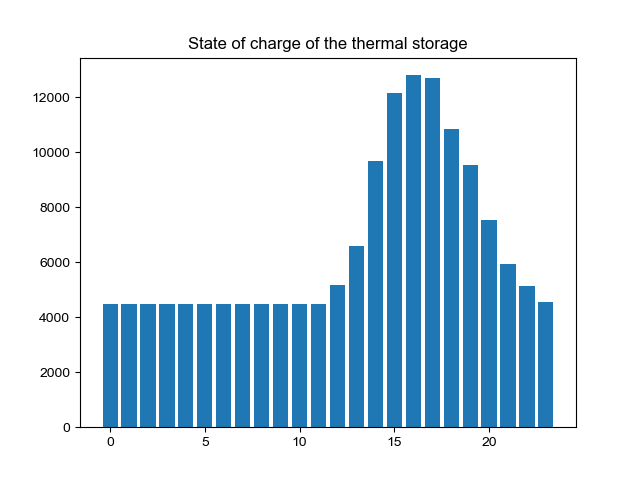

(<BarContainer object of 24 artists>,
 <Figure size 640x480 with 1 Axes>)

In [29]:
# SHOW THE GRAPH
# Storage SOC
plot_quantity_bar(time=time, quantity=elec_batteries.e,
                  title="State of charge of the thermal storage")

Otherwise, the profiles from all the energy units connected to a node can be plotted as follow.

<IPython.core.display.Javascript object>


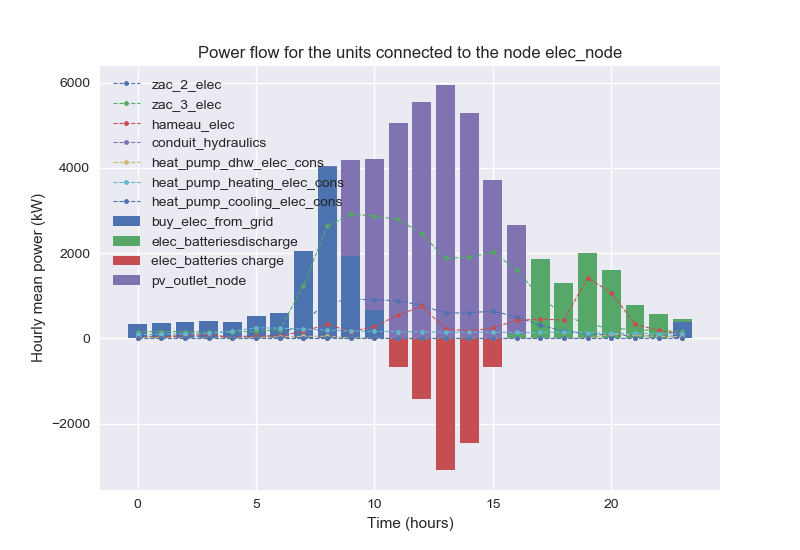


Preparing to plot the energetic flows through the node elec_node.
	Add power from buy_elec_from_grid.
	Add power from zac_2_elec.
	Add power from zac_3_elec.
	Add power from hameau_elec.
	Add power from conduit_hydraulics.
	Add power from elec_batteries.
	Add power from heat_pump_dhw_elec_cons.
	Add power from heat_pump_heating_elec_cons.
	Add power from heat_pump_cooling_elec_cons.
	Add power from pv_outlet_node.


<module 'matplotlib.pyplot' from 'C:\\Anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [30]:
# Recovered and dissipated heat
plot_node_energetic_flows(elec_node)

<IPython.core.display.Javascript object>


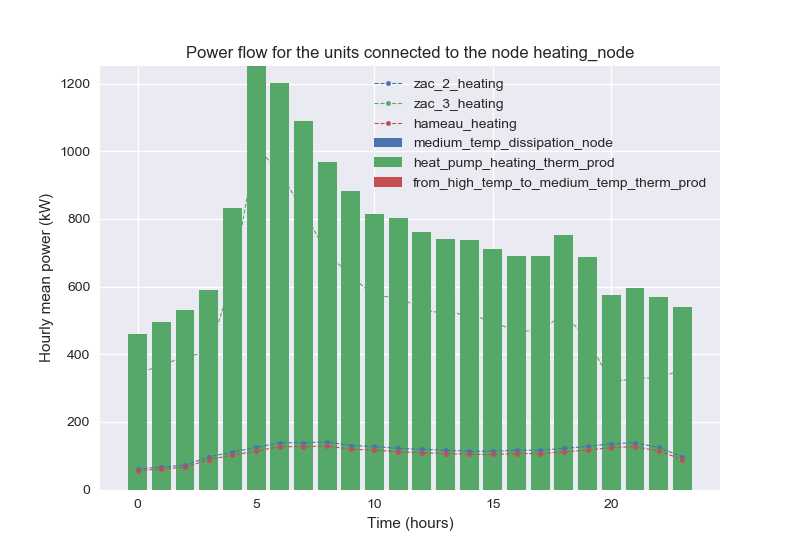


Preparing to plot the energetic flows through the node heating_node.
	Add power from medium_temp_dissipation_node.
	Add power from heat_pump_heating_therm_prod.
	Add power from zac_2_heating.
	Add power from zac_3_heating.
	Add power from hameau_heating.
	Add power from from_high_temp_to_medium_temp_therm_prod.


<module 'matplotlib.pyplot' from 'C:\\Anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [31]:


# Energy on the recovery system
plot_node_energetic_flows(heating_node)

<IPython.core.display.Javascript object>


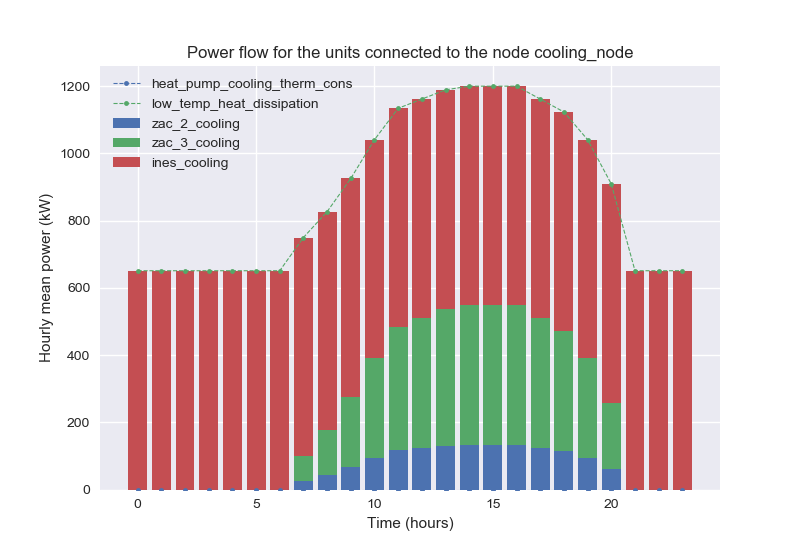


Preparing to plot the energetic flows through the node cooling_node.
	Add power from zac_2_cooling.
	Add power from zac_3_cooling.
	Add power from ines_cooling.
	Add power from heat_pump_cooling_therm_cons.
	Add power from low_temp_heat_dissipation.


<module 'matplotlib.pyplot' from 'C:\\Anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [32]:


# Energy on the district heating network
plot_node_energetic_flows(cooling_node)

<IPython.core.display.Javascript object>


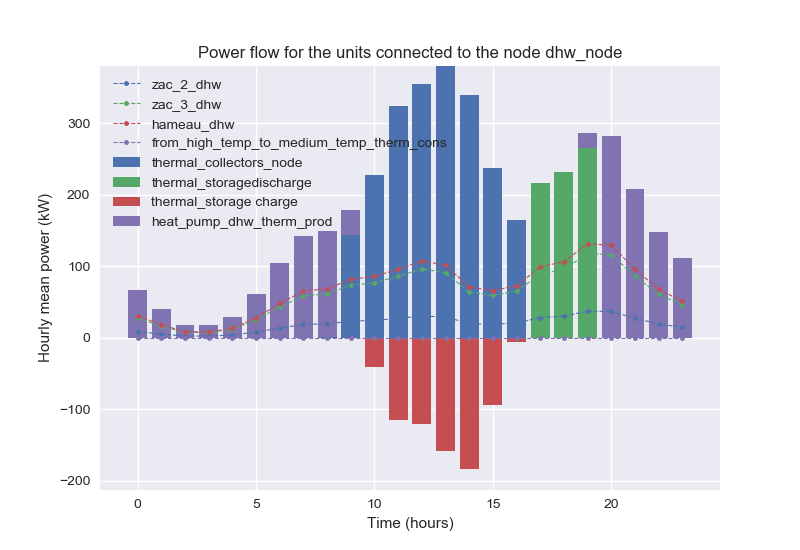


Preparing to plot the energetic flows through the node dhw_node.
	Add power from thermal_collectors_node.
	Add power from thermal_storage.
	Add power from zac_2_dhw.
	Add power from zac_3_dhw.
	Add power from hameau_dhw.
	Add power from heat_pump_dhw_therm_prod.
	Add power from from_high_temp_to_medium_temp_therm_cons.


<module 'matplotlib.pyplot' from 'C:\\Anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [33]:


# Energy on the district heating network
plot_node_energetic_flows(dhw_node)

## Exergy model and Solving <a class="anchor" id="chapter2"></a>

### Importing energy models <a class="anchor" id="chapter21"></a>

In this section, the possibilities offered by the exergy module developped and integrated by the LOCIE are presented related to the considered use case.



In [34]:
from python_scripts.NB_beaulac_project_locie import beaulac_project_init

lake, buy_elec_from_grid, sell_elec_to_grid, zac_2_elec, zac_3_elec, hameau_elec, conduit_hydraulics, zac_2_dhw, \
zac_3_dhw, hameau_dhw, zac_2_heating, zac_3_heating, hameau_heating, solar_irradiation_pv, solar_irradiation_st, zac_2_cooling, \
zac_3_cooling, ines_cooling, elec_batteries, high_temp_heat_dissipation, medium_temp_heat_dissipation, low_temp_heat_dissipation, \
thermal_storage, pv_panels, solar_thermal_collectors, \
heat_pump_dhw, heat_pump_heating, heat_pump_cooling, from_high_temp_to_medium_temp, imaginary_elec_prod_unit = beaulac_project_init(work_path=work_path,
                                   exergy_analysis=False, time = time,
                                   time_lapse=TIME_LAPSE,
                                   temp_dead_state=DEAD_STATE_TEMPERATURE,
                                   st_area=ST_COLLECTORS_AREA,
                                   st_efficiency=ST_COLLECTORS_EFF,
                                   st_temp_out=ST_COLLECTORS_OUTLET_TEMPERATURE,
                                   pv_area=PV_PANELS_AREA,
                                   pv_efficiency=PV_PANELS_EFF,
                                   p_max_lake=LAKE_MAX_THERMAL_POWER,
                                   conduit_max_cooling=CONDUIT_MAX_COOLING_POWER,
                                   elec_batt_pc_max=ELEC_BATT_MAX_CHARGE_POWER,
                                   elec_batt_pd_max=ELEC_BATT_MAX_DISCHARGE_POWER,
                                   elec_batt_capa=ELEC_BATT_CAPA,
                                   elec_batt_soc_min=ELEC_BATT_SOC_MIN,
                                   elec_batt_soc_max=ELEC_BATT_SOC_MAX,
                                   elec_batt_self_disch=ELEC_BATT_SELF_DISCHARGE,
                                   elec_batt_soc_ini=ELEC_BATT_SOC_INI,
                                   therm_stor_pc_max=THERMAL_STORAGE_MAX_POWER_CHARGE,
                                   therm_stor_pd_max = THERMAL_STORAGE_MAX_POWER_DISCHARGE,
                                   therm_stor_capa=THERMAL_STORAGE_CAPACITY,
                                   therm_stor_soc_min=THERMAL_STORAGE_SOC_MIN,
                                   therm_stor_soc_max=THERMAL_STORAGE_SOC_MAX,
                                   therm_stor_self_disch=THERMAL_STORAGE_SELF_DISCHARGE,
                                   therm_stor_soc_ini=THERMAL_STORAGE_SOC_INI,
                                   therm_stor_temp=THERMAL_STORAGE_TEMPERATURE,
                                   hp_heating_cop=HEAT_PUMP_HEATING_COP,
                                   hp_heating_pmax_elec=HEAT_PUMP_HEATING_PMAX_ELEC,
                                   hp_heating_temp_in=HEAT_PUMP_HEATING_INLET_TEMPERATURE,
                                   hp_heating_temp_out=HEAT_PUMP_HEATING_OUTLET_TEMPERATURE,
                                   hp_dhw_cop=HEAT_PUMP_DHW_COP,
                                   hp_dhw_pmax_elec=HEAT_PUMP_DHW_PMAX_ELEC,
                                   hp_dhw_temp_in=HEAT_PUMP_DHW_INLET_TEMPERATURE,
                                   hp_dhw_temp_out=HEAT_PUMP_DHW_OUTLET_TEMPERATURE,
                                   hp_cooling_cop=HEAT_PUMP_COOLING_COP,
                                   hp_cooling_pmax_elec=HEAT_PUMP_COOLING_PMAX_ELEC,
                                   hp_cooling_temp_in=HEAT_PUMP_COOLING_INLET_TEMPERATURE,
                                   hp_cooling_temp_out=HEAT_PUMP_COOLING_OUTLET_TEMPERATURE,
                                   fluid_pumps_exergy_eff=FLUID_PUMPS_EFFICIENCY,
                                   high_heat_diss_temp=HEAT_DISSIPATION_HIGH_TEMPERATURE,
                                   medium_heat_diss_temp=HEAT_DISSIPATION_MEDIUM_TEMPERATURE,
                                   low_heat_diss_temp=HEAT_DISSIPATION_LOW_TEMPERATURE,
                                   heat_diss_exergy_eff=HEAT_DISSIPATION_EXERGY_EFF
                                   )

Creating the lake.
Creating the buy_elec_from_grid.
Creating the sell_elec_to_grid.
Creating the zac_2_elec.
Creating the zac_3_elec.
Creating the hameau_elec.
Creating the conduit_hydraulics.
Creating the zac_2_dhw.
Creating the zac_3_dhw.
Creating the hameau_dhw.
Creating the zac_2_heating.
Creating the zac_3_heating.
Creating the hameau_heating.
Creating the zac_2_cooling.
Creating the zac_3_cooling.
Creating the ines_cooling.
Creating the solar_irradiation_pv.
Creating the pv_panels_elec_prod.
Creating the pv_panels_elec_cons.
Creating the pv_panels.
Creating the solar_irradiation_st.
Creating the solar_thermal_collectors_therm_prod.
Creating the solar_thermal_collectors_elec_cons.
Creating the solar_thermal_collectors.
Creating the elec_batteries.
Creating the thermal_storage.
Creating the high_temp_heat_dissipation.
Creating the medium_temp_heat_dissipation.
Creating the low_temp_heat_dissipation.
Creating the heat_pump_heating_therm_prod.
Creating the heat_pump_heating_therm_con

### Importing and set exergy models <a class="anchor" id="chapter22"></a>

Then, the exergy layer has to be implemented thanks to the ElectricalExergy adn ThermalExergy objects. Then, the exergy destruction is determined thanks to the additionnal ExergyDestruction object.

In [35]:
ElectricalExergy(energy_unit=pv_panels.elec_consumption_unit)
ElectricalExergy(energy_unit=pv_panels.elec_production_unit)
ExergyDestruction(energy_unit=pv_panels)

ElectricalExergy(energy_unit=solar_thermal_collectors.elec_consumption_unit)
ThermalExergy(energy_unit=solar_thermal_collectors.thermal_production_unit,
              temp_heat=ST_COLLECTORS_OUTLET_TEMPERATURE, temp_ref=DEAD_STATE_TEMPERATURE)
ExergyDestruction(energy_unit=solar_thermal_collectors)

ElectricalExergy(energy_unit=conduit_hydraulics)
ExergyDestruction(energy_unit=conduit_hydraulics,
                  exergy_eff=FLUID_PUMPS_EFFICIENCY)

ElectricalExergy(energy_unit=elec_batteries)
ExergyDestruction(energy_unit=elec_batteries, temp_heat=50000,
                  temp_ref=DEAD_STATE_TEMPERATURE)

ThermalExergy(energy_unit=thermal_storage, temp_heat=THERMAL_STORAGE_TEMPERATURE,
              temp_ref=DEAD_STATE_TEMPERATURE)
ExergyDestruction(energy_unit=thermal_storage,
                  temp_heat=THERMAL_STORAGE_TEMPERATURE,
                  temp_ref=DEAD_STATE_TEMPERATURE)

ThermalExergy(energy_unit=high_temp_heat_dissipation,
              temp_heat=HEAT_DISSIPATION_HIGH_TEMPERATURE, temp_ref=DEAD_STATE_TEMPERATURE)
ExergyDestruction(energy_unit=high_temp_heat_dissipation,
                  exergy_eff=FLUID_PUMPS_EFFICIENCY)

ThermalExergy(energy_unit=medium_temp_heat_dissipation,
              temp_heat=HEAT_DISSIPATION_MEDIUM_TEMPERATURE, temp_ref=FLUID_PUMPS_EFFICIENCY)
ExergyDestruction(energy_unit=medium_temp_heat_dissipation,
                  exergy_eff=FLUID_PUMPS_EFFICIENCY)

ThermalExergy(energy_unit=low_temp_heat_dissipation,
              temp_heat=HEAT_DISSIPATION_LOW_TEMPERATURE, temp_ref=DEAD_STATE_TEMPERATURE)
ExergyDestruction(energy_unit=low_temp_heat_dissipation,
                  exergy_eff=FLUID_PUMPS_EFFICIENCY)

ElectricalExergy(energy_unit=heat_pump_dhw.elec_consumption_unit)
ThermalExergy(energy_unit=heat_pump_dhw.thermal_consumption_unit,
              temp_heat=HEAT_PUMP_DHW_INLET_TEMPERATURE, temp_ref=DEAD_STATE_TEMPERATURE)
ThermalExergy(energy_unit=heat_pump_dhw.thermal_production_unit,
              temp_heat=HEAT_PUMP_DHW_OUTLET_TEMPERATURE, temp_ref=DEAD_STATE_TEMPERATURE)
ExergyDestruction(energy_unit=heat_pump_dhw)

ElectricalExergy(energy_unit=heat_pump_heating.elec_consumption_unit)
ThermalExergy(energy_unit=heat_pump_heating.thermal_consumption_unit,
              temp_heat=HEAT_PUMP_HEATING_INLET_TEMPERATURE, temp_ref=DEAD_STATE_TEMPERATURE)
ThermalExergy(energy_unit=heat_pump_heating.thermal_production_unit,
              temp_heat=HEAT_PUMP_HEATING_OUTLET_TEMPERATURE, temp_ref=DEAD_STATE_TEMPERATURE)
ExergyDestruction(energy_unit=heat_pump_heating)

# - Cooling heat pump -
ElectricalExergy(energy_unit=heat_pump_cooling.elec_consumption_unit)
ThermalExergy(energy_unit=heat_pump_cooling.thermal_consumption_unit,
              temp_heat=HEAT_PUMP_COOLING_INLET_TEMPERATURE, temp_ref=DEAD_STATE_TEMPERATURE)
ThermalExergy(energy_unit=heat_pump_cooling.thermal_production_unit,
              temp_heat=HEAT_PUMP_COOLING_OUTLET_TEMPERATURE, temp_ref=DEAD_STATE_TEMPERATURE)
ExergyDestruction(energy_unit=heat_pump_cooling)

" Imaginary heat pump representing use of high temp heat for medium temp needs "
ElectricalExergy(energy_unit=from_high_temp_to_medium_temp.elec_consumption_unit)
ThermalExergy(energy_unit=from_high_temp_to_medium_temp.thermal_consumption_unit,
              temp_heat=HEAT_PUMP_DHW_OUTLET_TEMPERATURE, temp_ref=DEAD_STATE_TEMPERATURE)
ThermalExergy(energy_unit=from_high_temp_to_medium_temp.thermal_production_unit,
              temp_heat=HEAT_PUMP_HEATING_OUTLET_TEMPERATURE, temp_ref=DEAD_STATE_TEMPERATURE)
ExergyDestruction(energy_unit=from_high_temp_to_medium_temp)

Creating the elect_exergy.
Creating the elect_exergy.
Creating the elec_exergy.
Creating the elect_exergy.
Creating the thermal_exergy.
Creating the elec_exergy.
Creating the elect_exergy.
Creating the elec_exergy.
Creating the elect_exergy.
Creating the elec_exergy.
Creating the thermal_exergy.
Creating the elec_exergy.
Creating the thermal_exergy.
Creating the elec_exergy.
Creating the thermal_exergy.
Creating the elec_exergy.
Creating the thermal_exergy.
Creating the elec_exergy.
Creating the elect_exergy.
Creating the thermal_exergy.
Creating the thermal_exergy.
Creating the elec_exergy.
Creating the elect_exergy.
Creating the thermal_exergy.
Creating the thermal_exergy.
Creating the elec_exergy.
Creating the elect_exergy.
Creating the thermal_exergy.
Creating the thermal_exergy.
Creating the elec_exergy.
Creating the elect_exergy.
Creating the thermal_exergy.
Creating the thermal_exergy.
Creating the elec_exergy.


<OMEGALPES.general.optimisation.units.OptObject: name:'elec_exergy'>

Then the modelisation process continues with the creation of the energy nodes and the connection of all the energy units as it has been done previously

In [36]:
elec_node = EnergyNode(time, name='elec_node', energy_type='Electrical')
pv_outlet_node = EnergyNode(time, name='pv_outlet_node', energy_type='Electrical')
solar_pv_node = EnergyNode(time, name='solar_pv_node', energy_type='Electrical')
solar_st_node = EnergyNode(time, name='solar_st_node', energy_type='Electrical')
thermal_collectors_node = EnergyNode(
    time, name='thermal_collectors_node', energy_type='Thermal')
lake_node = EnergyNode(time, name='lake_node', energy_type='Thermal')
cooling_node = EnergyNode(time, name='cooling_node', energy_type='Thermal')
medium_temp_dissipation_node = EnergyNode(
    time, name='medium_temp_dissipation_node', energy_type='Thermal')
heating_node = EnergyNode(
    time, name='heating_node', energy_type='Thermal')
dhw_node = EnergyNode(time, name='dhw_node', energy_type='Thermal')
imaginary_elec_node = EnergyNode(time, name='imaginary_elec_node', energy_type='Electrical')

elec_node.connect_units(buy_elec_from_grid, zac_2_elec, zac_3_elec, hameau_elec,
                        conduit_hydraulics, elec_batteries,
                        heat_pump_dhw.elec_consumption_unit,
                        heat_pump_heating.elec_consumption_unit,
                        heat_pump_cooling.elec_consumption_unit)
pv_outlet_node.connect_units(pv_panels.elec_production_unit, sell_elec_to_grid)
pv_outlet_node.export_to_node(elec_node)

solar_pv_node.connect_units(solar_irradiation_pv,
                            pv_panels.elec_consumption_unit)
solar_st_node.connect_units(solar_irradiation_st,
                            solar_thermal_collectors.elec_consumption_unit)
thermal_collectors_node.connect_units(solar_thermal_collectors.thermal_production_unit,
                                      high_temp_heat_dissipation)
thermal_collectors_node.export_to_node(dhw_node)

lake_node.connect_units(lake, heat_pump_dhw.thermal_consumption_unit,
                            heat_pump_heating.thermal_consumption_unit
                        )

cooling_node.connect_units(zac_2_cooling, zac_3_cooling, ines_cooling,
                           heat_pump_cooling.thermal_consumption_unit,
                           low_temp_heat_dissipation,
                           )
medium_temp_dissipation_node.connect_units(medium_temp_heat_dissipation,
    heat_pump_cooling.thermal_production_unit)
medium_temp_dissipation_node.export_to_node(heating_node)

heating_node.connect_units(heat_pump_heating.thermal_production_unit,
                           zac_2_heating, zac_3_heating, hameau_heating,
                           from_high_temp_to_medium_temp.thermal_production_unit)

dhw_node.connect_units(thermal_storage, zac_2_dhw, zac_3_dhw,
                       hameau_dhw, heat_pump_dhw.thermal_production_unit,
                       from_high_temp_to_medium_temp.thermal_consumption_unit)

imaginary_elec_node.connect_units(imaginary_elec_prod_unit, from_high_temp_to_medium_temp.elec_consumption_unit
                                  )

Creating the elec_node.
Creating the pv_outlet_node.
Creating the solar_pv_node.
Creating the solar_st_node.
Creating the thermal_collectors_node.
Creating the lake_node.
Creating the cooling_node.
Creating the medium_temp_dissipation_node.
Creating the heating_node.
Creating the dhw_node.
Creating the imaginary_elec_node.


### Apply specific exergy objective function <a class="anchor" id="chapter23"></a>

Then the objective function are integrated considering the previous ones in addition to exergy destruction minimization

In [37]:
""" EXERGY-FOCUSED OPTIMIZATION OBJECTIVES """
heat_pump_dhw.minimize_exergy_destruction()
heat_pump_heating.minimize_exergy_destruction()
heat_pump_cooling.minimize_exergy_destruction()
elec_batteries.minimize_exergy_destruction()
thermal_storage.minimize_exergy_destruction()
high_temp_heat_dissipation.minimize_exergy_destruction()
medium_temp_heat_dissipation.minimize_exergy_destruction()
low_temp_heat_dissipation.minimize_exergy_destruction()



### Solving process <a class="anchor" id="chapter24"></a>

In [38]:
model = OptimisationModel(time, name='optimization_model')
model.verbose = 0
model.add_nodes(elec_node, pv_outlet_node, solar_pv_node, solar_st_node, 
                lake_node, cooling_node,
                medium_temp_dissipation_node, heating_node, dhw_node,
                thermal_collectors_node, imaginary_elec_node)
model.solve_and_update()

C:\Anaconda\lib\site-packages\omegalpes\general\optimisation\model.py:588: UserWarning: The unit heat_pump_dhw seems to have as parent min_exergy_destruction which was not declared as parent.
  'parent.'.format(unit.name, parent_name))
C:\Anaconda\lib\site-packages\omegalpes\general\optimisation\model.py:588: UserWarning: The unit heat_pump_heating seems to have as parent min_exergy_destruction which was not declared as parent.
  'parent.'.format(unit.name, parent_name))
C:\Anaconda\lib\site-packages\omegalpes\general\optimisation\model.py:588: UserWarning: The unit heat_pump_cooling seems to have as parent min_exergy_destruction which was not declared as parent.
  'parent.'.format(unit.name, parent_name))
C:\Anaconda\lib\site-packages\omegalpes\general\optimisation\model.py:575: UserWarning: The unit pv_outlet_node seems to have as parent set_export_min_elec_node_min which was not declared as parent.
  'parent.'.format(unit.name, parent_name))
C:\Anaconda\lib\site-packages\omegalpes\g


--- Adding all variables to the model ---

--- Adding all objectives to the model ---

--- Adding all constraints to the model ---

 - - - - - RUN OPTIMIZATION - - - - - 
Resolution duration = 0.27951645851135254 seconds.

 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : buy_elec_from_grid
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : zac_2_elec
	Quantity : p
	Quantity : e_tot
Updating unit : zac_3_elec
	Quantity : p
	Quantity : e_tot
Updating unit : hameau_elec
	Quantity : p
	Quantity : e_tot
Updating unit : conduit_hydraulics
	Quantity : p
	Quantity : e_tot
	Quantity : exergy
	Quantity : exergy_dest
	Quantity : exd_tot
Updating unit : elec_batteries
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc_max
	Quantity : pd_max
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
	Quantity : exergy
	Quantity : exergy_dest
	Quantity : exd_tot
Updating unit : heat_pump_dhw_elec_cons
	Quantity 

### Output assessments <a class="anchor" id="chapter25"></a>

#### Energy scalar outputs <a class="anchor" id="chapter251"></a>

In [39]:
grid = [a for a in buy_elec_from_grid.p.value.values()]
pv = [b for b in pv_outlet_node.energy_export_to_elec_node.get_value()]
# bat = [c for c in elec_batteries.discharge.p.value.values()]
bat = [c for c in elec_batteries.pd.value.values()]
zac2 = [d for d in zac_2_elec.p.value]
zac3 = [e for e in zac_3_elec.p.value]
ham = [f for f in hameau_elec.p.value]
hpco = [g for g in heat_pump_cooling.elec_consumption_unit.p.value.values()]
hphe = [h for h in heat_pump_heating.elec_consumption_unit.p.value.values()]
hpdw = [i for i in heat_pump_dhw.elec_consumption_unit.p.value.values()]

total_resid_elec_demands = [d+e+f for d, e, f in zip(zac2, zac3, ham)]
total_renewable_elec_prod = [b for b in pv]
resid_elec_demands_covered_by_pv = [min(b, d+e+f) for b, d, e, f in zip(pv, zac2, zac3, ham)]
resid_elec_demands_covered_by_grid = [min(a, b-c) for a, b, c in zip(grid,
                                                                     total_resid_elec_demands,
                                                                     resid_elec_demands_covered_by_pv)]
hp_cooling_elec_cons_covered_by_pv = [min(a, max(0, b-c)) for a, b, c in zip(hpco,
                                                                             total_renewable_elec_prod,
                                                                             resid_elec_demands_covered_by_pv)]
hp_cooling_elec_cons_covered_by_grid = [a-b for a, b in zip(hpco, hp_cooling_elec_cons_covered_by_pv)]
hp_heating_elec_cons_covered_by_pv = [min(a, max(0, b-c-d)) for a, b, c, d in zip(hphe,
                                                                             total_renewable_elec_prod,
                                                                             resid_elec_demands_covered_by_pv,
                                                                             hp_cooling_elec_cons_covered_by_pv)]
hp_heating_elec_cons_covered_by_grid = [a - b for a, b in zip(hphe, hp_heating_elec_cons_covered_by_pv)]
hp_dhw_elec_cons_covered_by_pv = [min(a, max(0, b -c -d -e)) for a, b, c, d, e in zip(hpdw,
                                                                          total_renewable_elec_prod,
                                                                          resid_elec_demands_covered_by_pv,
                                                                          hp_cooling_elec_cons_covered_by_pv,
                                                                          hp_heating_elec_cons_covered_by_pv)]
hp_dhw_elec_cons_covered_by_grid = [a - b for a, b in zip(hpdw, hp_dhw_elec_cons_covered_by_pv)]

total_heat_pumps_electricity_consumption = [g + h + i for g, h, i in zip(hpco, hphe, hpdw)]
heat_pumps_elec_cons_covered_by_pv = [a+b+c for a, b, c in zip(hp_cooling_elec_cons_covered_by_pv,
                                                               hp_heating_elec_cons_covered_by_pv,
                                                               hp_dhw_elec_cons_covered_by_pv)]
heat_pumps_elec_cons_covered_by_grid = [a + b + c for a, b, c in zip(hp_cooling_elec_cons_covered_by_grid,
                                                                   hp_heating_elec_cons_covered_by_grid,
                                                                   hp_dhw_elec_cons_covered_by_grid)]

print('  ')
print('ENERGY ANALYSIS:')
print('  ')
print('Heat supplied by the anergy conduit = {0} kWh.'.
      format(round(lake.e_tot.value, 2)))
print('Electricity bought from the Grid = {0} kWh.'.
      format(round(buy_elec_from_grid.e_tot.value, 2)))
print('Electricity sold to the Grid = {0} kWh.'.
      format(round(sell_elec_to_grid.e_tot.value, 2)))
print('zac_2_elec = {0} kWh.'.
      format(round(zac_2_elec.e_tot.value, 2)))
print('zac_3_elec = {0} kWh.'.format(round(zac_3_elec.e_tot.value, 2)))
print('hameau_elec = {0} kWh.'.format(round(hameau_elec.e_tot.value, 2)))
print('conduit_hydraulics = {0} kWh.'.
      format(round(conduit_hydraulics.e_tot.value, 2)))
print('zac_2_dhw = {0} kWh.'.format(round(zac_2_dhw.e_tot.value, 2)))
print('zac_3_dhw = {0} kWh.'.format(round(zac_3_dhw.e_tot.value, 2)))
print('hameau_dhw = {0} kWh.'.format(round(hameau_dhw.e_tot.value, 2)))
print('zac_2_heating = {0} kWh.'.format(round(zac_2_heating.e_tot.value, 2)))
print('zac_3_heating = {0} kWh.'.format(round(zac_3_heating.e_tot.value, 2)))
print('hameau_heating = {0} kWh.'.format(round(hameau_heating.e_tot.value, 2)))
print('zac_2_cooling = {0} kWh.'.
      format(round(zac_2_cooling.e_tot.value, 2)))
print('zac_3_cooling = {0} kWh.'.
      format(round(zac_3_cooling.e_tot.value, 2)))
print('ines_cooling = {0} kWh.'.
      format(round(ines_cooling.e_tot.value, 2)))
# print('elec_batteries = {0} kWh.'.
#      format(round(elec_batteries.e_tot.value, 2)))
print('high_temperature_heat_dissipation = {0} kWh.'.
      format(round(high_temp_heat_dissipation.e_tot.value, 2)))
print('medium_temperature_heat_dissipation = {0} kWh.'.
      format(round(medium_temp_heat_dissipation.e_tot.value, 2)))
print('low_temperature_heat_dissipation = {0} kWh.'.
      format(round(low_temp_heat_dissipation.e_tot.value, 2)))
print('thermal_storage = {0} kWh.'.
     format(round(thermal_storage.e_tot.value, 2)))

print('pv_panels_solar_cons = {0} kWh.'.format(
    round(pv_panels.elec_consumption_unit.e_tot.value, 2)))
print('pv_panels_elec_prod = {0} kWh.'.format(
    round(pv_panels.elec_production_unit.e_tot.value, 2)))
print('st_coll_solar_cons = {0} kWh.'.format(
    round(solar_thermal_collectors.elec_consumption_unit.e_tot.value, 2)))
print('st_coll_thermal_prod = {0} kWh.'.format(
    round(solar_thermal_collectors.thermal_production_unit.e_tot.value, 2)))
print('hp_dhw_elec_cons = {0} kWh.'.format(
    round(heat_pump_dhw.elec_consumption_unit.e_tot.value, 2)))
print('hp_dhw_thermal_cons = {0} kWh.'.format(
    round(heat_pump_dhw.thermal_consumption_unit.e_tot.value, 2)))
print('hp_dhw_thermal_prod = {0} kWh.'.format(
    round(heat_pump_dhw.thermal_production_unit.e_tot.value, 2)))
print('hp_heating_elec_cons = {0} kWh.'.format(
    round(heat_pump_heating.elec_consumption_unit.e_tot.value, 2)))
print('hp_heating_thermal_cons = {0} kWh.'.format(
    round(heat_pump_heating.thermal_consumption_unit.e_tot.value, 2)))
print('hp_heating_thermal_prod = {0} kWh.'.format(
    round(heat_pump_heating.thermal_production_unit.e_tot.value, 2)))
print('hp_cooling_elec_cons = {0} kWh.'.format(
    round(heat_pump_cooling.elec_consumption_unit.e_tot.value, 2)))
print('hp_cooling_thermal_cons = {0} kWh.'.format(
    round(heat_pump_cooling.thermal_consumption_unit.e_tot.value, 2)))
print('hp_cooling_thermal_prod = {0} kWh.'.format(
    round(heat_pump_cooling.thermal_production_unit.e_tot.value, 2)))

  
ENERGY ANALYSIS:
  
Heat supplied by the anergy conduit = 15326.12 kWh.
Electricity bought from the Grid = 46033.52 kWh.
Electricity sold to the Grid = 33957.9 kWh.
zac_2_elec = 8236.48 kWh.
zac_3_elec = 26082.2 kWh.
hameau_elec = 7623.4 kWh.
conduit_hydraulics = 0.0 kWh.
zac_2_dhw = 467.13 kWh.
zac_3_dhw = 1479.25 kWh.
hameau_dhw = 1648.28 kWh.
zac_2_heating = 2764.1 kWh.
zac_3_heating = 12670.91 kWh.
hameau_heating = 2531.1 kWh.
zac_2_cooling = 1389.93 kWh.
zac_3_cooling = 4357.62 kWh.
ines_cooling = 15616.44 kWh.
high_temperature_heat_dissipation = 0.0 kWh.
medium_temperature_heat_dissipation = 0.0 kWh.
low_temperature_heat_dissipation = 21363.99 kWh.
thermal_storage = 5.57 kWh.
pv_panels_solar_cons = 226386.03 kWh.
pv_panels_elec_prod = 33957.9 kWh.
st_coll_solar_cons = 2712.97 kWh.
st_coll_thermal_prod = 2170.38 kWh.
hp_dhw_elec_cons = 476.62 kWh.
hp_dhw_thermal_cons = 953.23 kWh.
hp_dhw_thermal_prod = 1429.85 kWh.
hp_heating_elec_cons = 3593.22 kWh.
hp_heating_thermal_cons = 1

#### Exergy scalar outputs <a class="anchor" id="chapter252"></a>

In [40]:
print('EXERGY ANALYSIS:')
print('  ')
print('Exergy destruction (PV PANELS) = {0} kWh.'.format(
    round(pv_panels.exd_tot.value, 2)))
print('Exergy destruction (ELECTRIC BATTERIES) = {0} kWh.'.format(
    round(elec_batteries.exd_tot.value, 2)))
print('Exergy destruction (ST COLLECTORS) = {0} kWh.'.format(
    round(solar_thermal_collectors.exd_tot.value, 2)))
print('Exergy destruction (THERMAL STORAGE) = {0} kWh.'.format(
    round(thermal_storage.exd_tot.value, 2)))
print('Exergy destruction (HP_DHW) = {0} kWh.'.format(
    round(heat_pump_dhw.exd_tot.value, 2)))
print('Exergy destruction (HP_HEATING) = {0} kWh.'.format(
    round(heat_pump_heating.exd_tot.value, 2)))
print('Exergy destruction (HP_COOLING) = {0} kWh.'.format(
    round(heat_pump_cooling.exd_tot.value, 2)))
print('Exergy destruction (HYDRAULIC PUMPS) = {0} kWh.'.format(
    round(conduit_hydraulics.exd_tot.value, 2)))
print('Exergy destruction (HIGH TEMP HEAT DISSIPATION) = {0} kWh.'.
    format(round(high_temp_heat_dissipation.exd_tot.value, 2)))
print('Exergy destruction (MEDIUM TEMP HEAT DISSIPATION) = {0} kWh.'.
      format(round(medium_temp_heat_dissipation.exd_tot.value, 2)))
print('Exergy destruction (LOW TEMP HEAT DISSIPATION) = {0} kWh.'.
      format(round(low_temp_heat_dissipation.exd_tot.value, 2)))
print('Exergy destruction (FROM HIGH TEMP TO MEDIUM TEMP) = {0} kWh.'.
      format(round(from_high_temp_to_medium_temp.exd_tot.value, 2)))

EXERGY ANALYSIS:
  
Exergy destruction (PV PANELS) = 192428.12 kWh.
Exergy destruction (ELECTRIC BATTERIES) = 21.49 kWh.
Exergy destruction (ST COLLECTORS) = 2225.17 kWh.
Exergy destruction (THERMAL STORAGE) = 1.25 kWh.
Exergy destruction (HP_DHW) = 216.5 kWh.
Exergy destruction (HP_HEATING) = 1834.76 kWh.
Exergy destruction (HP_COOLING) = 0.0 kWh.
Exergy destruction (HYDRAULIC PUMPS) = 0.0 kWh.
Exergy destruction (HIGH TEMP HEAT DISSIPATION) = 0.0 kWh.
Exergy destruction (MEDIUM TEMP HEAT DISSIPATION) = 0.0 kWh.
Exergy destruction (LOW TEMP HEAT DISSIPATION) = 192.77 kWh.
Exergy destruction (FROM HIGH TEMP TO MEDIUM TEMP) = 0.0 kWh.


#### Plotting energy flow and profiles <a class="anchor" id="chapter253"></a>

For the plotting, it is feasible to extract the profile to plot from any energy unit and quantities as follow

<IPython.core.display.Javascript object>


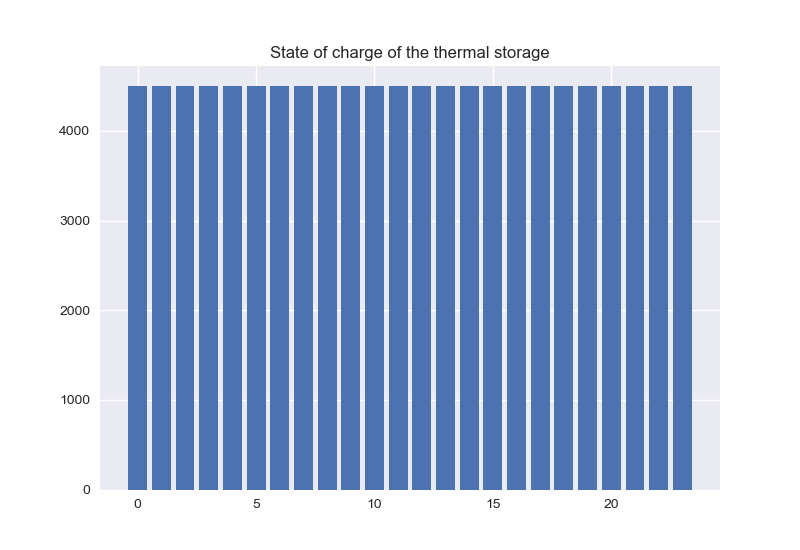

(<BarContainer object of 24 artists>,
 <Figure size 800x550 with 1 Axes>)

In [41]:
# SHOW THE GRAPH
# Storage SOC
plot_quantity_bar(time=time, quantity=elec_batteries.e,
                  title="State of charge of the thermal storage")

Otherwise, the profiles from all the energy units connected to a node can be plotted as follow.

<IPython.core.display.Javascript object>


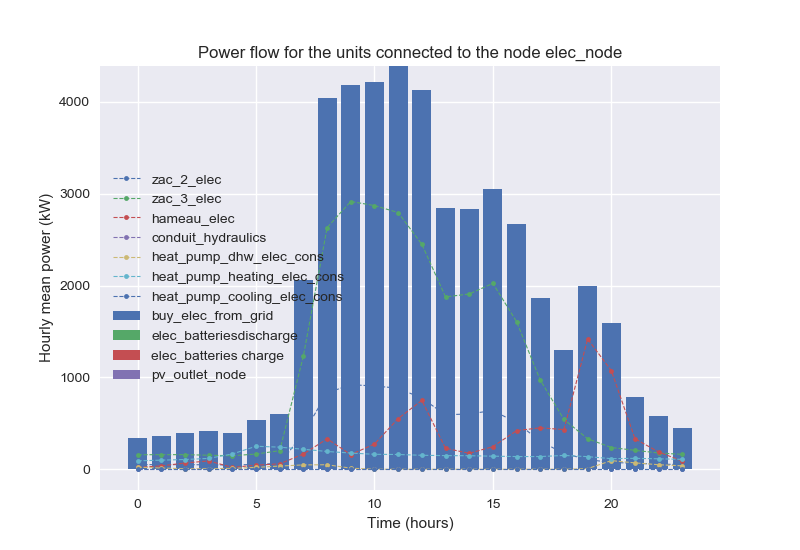


Preparing to plot the energetic flows through the node elec_node.
	Add power from buy_elec_from_grid.
	Add power from zac_2_elec.
	Add power from zac_3_elec.
	Add power from hameau_elec.
	Add power from conduit_hydraulics.
	Add power from elec_batteries.
	Add power from heat_pump_dhw_elec_cons.
	Add power from heat_pump_heating_elec_cons.
	Add power from heat_pump_cooling_elec_cons.
	Add power from pv_outlet_node.


<module 'matplotlib.pyplot' from 'C:\\Anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [42]:
# Recovered and dissipated heat
plot_node_energetic_flows(elec_node)

<IPython.core.display.Javascript object>


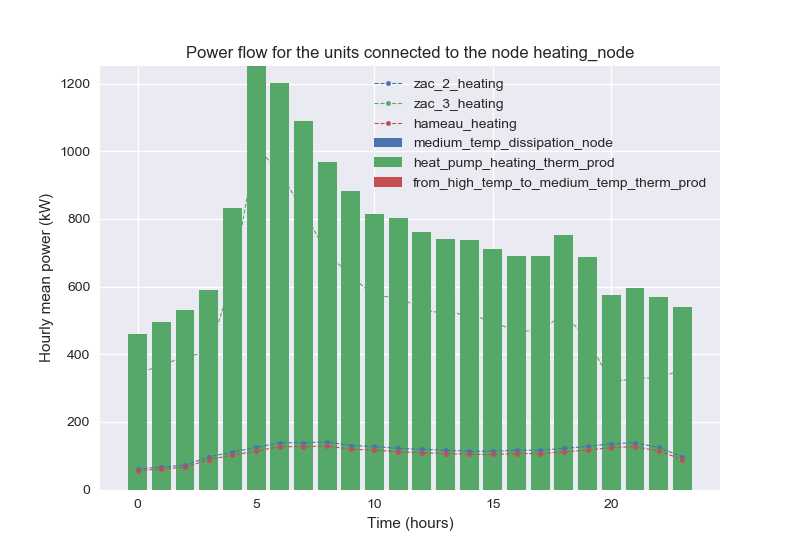


Preparing to plot the energetic flows through the node heating_node.
	Add power from medium_temp_dissipation_node.
	Add power from heat_pump_heating_therm_prod.
	Add power from zac_2_heating.
	Add power from zac_3_heating.
	Add power from hameau_heating.
	Add power from from_high_temp_to_medium_temp_therm_prod.


<module 'matplotlib.pyplot' from 'C:\\Anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [43]:


# Energy on the recovery system
plot_node_energetic_flows(heating_node)

<IPython.core.display.Javascript object>


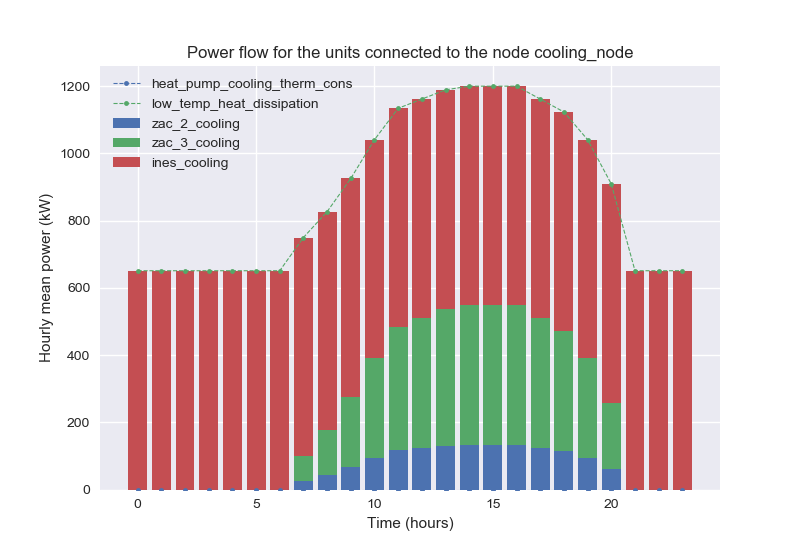


Preparing to plot the energetic flows through the node cooling_node.
	Add power from zac_2_cooling.
	Add power from zac_3_cooling.
	Add power from ines_cooling.
	Add power from heat_pump_cooling_therm_cons.
	Add power from low_temp_heat_dissipation.


<module 'matplotlib.pyplot' from 'C:\\Anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [44]:


# Energy on the district heating network
plot_node_energetic_flows(cooling_node)

<IPython.core.display.Javascript object>


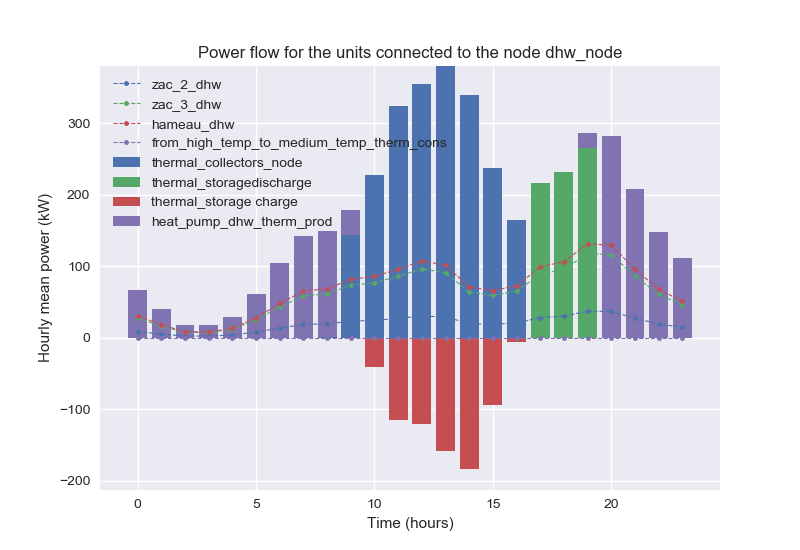


Preparing to plot the energetic flows through the node dhw_node.
	Add power from thermal_collectors_node.
	Add power from thermal_storage.
	Add power from zac_2_dhw.
	Add power from zac_3_dhw.
	Add power from hameau_dhw.
	Add power from heat_pump_dhw_therm_prod.
	Add power from from_high_temp_to_medium_temp_therm_cons.


<module 'matplotlib.pyplot' from 'C:\\Anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [45]:


# Energy on the district heating network
plot_node_energetic_flows(dhw_node)

## Change the design parameters of thermal and electric solar production and storage <a class="anchor" id="chapter3"></a>

### Load a CSV file <a class="anchor" id="chapter31"></a>

The first two examples serve to demonstrate the energy and power modelling possible using the OMEGAlpes tool for this project.

In the following section, we will see how to modify the ratios of solar thermal and electrical production as well as the thermal and electrical storage capacities. 

In this section, it will be possible to record the results in a csv file containing all the results produced by this notebook.

First, please assign a link to a folder were the csv can be created in the following script. 

In [46]:
csv_path = "C:/Users/brugerma/PycharmProjects/Test/" # "C:/Users/username/folderexample0/folderexample1/" 
csv_name = "example_name.csv"

### Loop design <a class="anchor" id="chapter32"></a>

The management of csv file and data is ensured thanks to the pandas package that needs to be imported

In [47]:
import pandas as pd

Then a dictionnary is created in order to support the different results produced in this section

In [48]:
data = {}
collect_data = pd.DataFrame.from_dict(data, orient='index',
                       columns=['objective_function', 'pv_area', 'e_capa', 'st_area', 'th_capa', 'TSC', 'TSS', 'ESC', 'ESS'])

From this part, a loop of can be set from now to the dataframe concatenation can be set as follows:
1. Choose the values corresponding to the solar panels areas and the storage capacities
2. Solve the model
3. Concatenate the dataframe in order to add the output values of the self-consumption indicators
4. Restart from 1. 

Once you get enough data, you can uncomment the script after the concatenation of dataframes in order to store it in your folder.

In [49]:
PV_PANELS_AREA = 42307  # m²

In [50]:
ELEC_BATT_CAPA = 0  # kWh (Capacity of electric batteries)
ELEC_BATT_MAX_CHARGE_POWER = 0.50 * ELEC_BATT_CAPA  # kW
ELEC_BATT_MAX_DISCHARGE_POWER = 0.50 * ELEC_BATT_CAPA  # kW
ELEC_BATT_SOC_MIN = 0.30  # % of maximal capacity
ELEC_BATT_SOC_MAX = 1.00  # % of maximal capacity
ELEC_BATT_SOC_INI = (0.5 * ELEC_BATT_SOC_MIN + 0.5 * ELEC_BATT_SOC_MAX) * ELEC_BATT_CAPA  # kWh
ELEC_BATT_SELF_DISCHARGE = 0.0002  # %/h with respect to stored energy

In [51]:
ST_COLLECTORS_AREA = 507  # m²

In [52]:
THERMAL_STORAGE_CAPACITY = 0  # kWh
THERMAL_STORAGE_MAX_POWER_CHARGE = 0.20 * THERMAL_STORAGE_CAPACITY  # kW
THERMAL_STORAGE_MAX_POWER_DISCHARGE = 0.20 * THERMAL_STORAGE_CAPACITY   # kW

Choose if you need a exergy_analysis or not

In [53]:
from python_scripts.NB_beaulac_project_locie import beaulac_project_5_obj_solving

collect_data = beaulac_project_5_obj_solving(work_path, time = time, collect_data = collect_data,
                                   time_lapse=TIME_LAPSE,
                                   temp_dead_state=DEAD_STATE_TEMPERATURE,
                                   st_area=ST_COLLECTORS_AREA,
                                   st_efficiency=ST_COLLECTORS_EFF,
                                   st_temp_out=ST_COLLECTORS_OUTLET_TEMPERATURE,
                                   pv_area=PV_PANELS_AREA,
                                   pv_efficiency=PV_PANELS_EFF,
                                   p_max_lake=LAKE_MAX_THERMAL_POWER,
                                   conduit_max_cooling=CONDUIT_MAX_COOLING_POWER,
                                   elec_batt_pc_max=ELEC_BATT_MAX_CHARGE_POWER,
                                   elec_batt_pd_max=ELEC_BATT_MAX_DISCHARGE_POWER,
                                   elec_batt_capa=ELEC_BATT_CAPA,
                                   elec_batt_soc_min=ELEC_BATT_SOC_MIN,
                                   elec_batt_soc_max=ELEC_BATT_SOC_MAX,
                                   elec_batt_self_disch=ELEC_BATT_SELF_DISCHARGE,
                                   elec_batt_soc_ini=ELEC_BATT_SOC_INI,
                                   therm_stor_pc_max=THERMAL_STORAGE_MAX_POWER_CHARGE,
                                   therm_stor_pd_max = THERMAL_STORAGE_MAX_POWER_DISCHARGE,
                                   therm_stor_capa=THERMAL_STORAGE_CAPACITY,
                                   therm_stor_soc_min=THERMAL_STORAGE_SOC_MIN,
                                   therm_stor_soc_max=THERMAL_STORAGE_SOC_MAX,
                                   therm_stor_self_disch=THERMAL_STORAGE_SELF_DISCHARGE,
                                   therm_stor_soc_ini=THERMAL_STORAGE_SOC_INI,
                                   therm_stor_temp=THERMAL_STORAGE_TEMPERATURE,
                                   hp_heating_cop=HEAT_PUMP_HEATING_COP,
                                   hp_heating_pmax_elec=HEAT_PUMP_HEATING_PMAX_ELEC,
                                   hp_heating_temp_in=HEAT_PUMP_HEATING_INLET_TEMPERATURE,
                                   hp_heating_temp_out=HEAT_PUMP_HEATING_OUTLET_TEMPERATURE,
                                   hp_dhw_cop=HEAT_PUMP_DHW_COP,
                                   hp_dhw_pmax_elec=HEAT_PUMP_DHW_PMAX_ELEC,
                                   hp_dhw_temp_in=HEAT_PUMP_DHW_INLET_TEMPERATURE,
                                   hp_dhw_temp_out=HEAT_PUMP_DHW_OUTLET_TEMPERATURE,
                                   hp_cooling_cop=HEAT_PUMP_COOLING_COP,
                                   hp_cooling_pmax_elec=HEAT_PUMP_COOLING_PMAX_ELEC,
                                   hp_cooling_temp_in=HEAT_PUMP_COOLING_INLET_TEMPERATURE,
                                   hp_cooling_temp_out=HEAT_PUMP_COOLING_OUTLET_TEMPERATURE,
                                   fluid_pumps_exergy_eff=FLUID_PUMPS_EFFICIENCY,
                                   high_heat_diss_temp=HEAT_DISSIPATION_HIGH_TEMPERATURE,
                                   medium_heat_diss_temp=HEAT_DISSIPATION_MEDIUM_TEMPERATURE,
                                   low_heat_diss_temp=HEAT_DISSIPATION_LOW_TEMPERATURE,
                                   heat_diss_exergy_eff=HEAT_DISSIPATION_EXERGY_EFF)

Creating the lake.
Creating the buy_elec_from_grid.
Creating the sell_elec_to_grid.
Creating the zac_2_elec.
Creating the zac_3_elec.
Creating the hameau_elec.
Creating the conduit_hydraulics.
Creating the zac_2_dhw.
Creating the zac_3_dhw.
Creating the hameau_dhw.


C:\Anaconda\lib\site-packages\omegalpes\general\optimisation\model.py:575: UserWarning: The unit pv_outlet_node seems to have as parent set_export_min_elec_node_min which was not declared as parent.
  'parent.'.format(unit.name, parent_name))
C:\Anaconda\lib\site-packages\omegalpes\general\optimisation\model.py:575: UserWarning: The unit medium_temp_dissipation_node seems to have as parent set_export_min_heating_node_min which was not declared as parent.
  'parent.'.format(unit.name, parent_name))
C:\Anaconda\lib\site-packages\omegalpes\general\optimisation\model.py:575: UserWarning: The unit thermal_collectors_node seems to have as parent set_export_min_dhw_node_min which was not declared as parent.
  'parent.'.format(unit.name, parent_name))


Creating the zac_2_heating.
Creating the zac_3_heating.
Creating the hameau_heating.
Creating the zac_2_cooling.
Creating the zac_3_cooling.
Creating the ines_cooling.
Creating the solar_irradiation_pv.
Creating the pv_panels_elec_prod.
Creating the pv_panels_elec_cons.
Creating the pv_panels.
Creating the solar_irradiation_st.
Creating the solar_thermal_collectors_therm_prod.
Creating the solar_thermal_collectors_elec_cons.
Creating the solar_thermal_collectors.
Creating the elec_batteries.
Creating the thermal_storage.
Creating the high_temp_heat_dissipation.
Creating the medium_temp_heat_dissipation.
Creating the low_temp_heat_dissipation.
Creating the heat_pump_heating_therm_prod.
Creating the heat_pump_heating_therm_cons.
Creating the heat_pump_heating_elec_cons.
Creating the heat_pump_heating.
Creating the heat_pump_dhw_therm_prod.
Creating the heat_pump_dhw_therm_cons.
Creating the heat_pump_dhw_elec_cons.
Creating the heat_pump_dhw.
Creating the heat_pump_cooling_therm_prod.
Cr

C:\Anaconda\lib\site-packages\omegalpes\general\optimisation\model.py:575: UserWarning: The unit pv_outlet_node seems to have as parent set_export_min_elec_node_min which was not declared as parent.
  'parent.'.format(unit.name, parent_name))
C:\Anaconda\lib\site-packages\omegalpes\general\optimisation\model.py:575: UserWarning: The unit medium_temp_dissipation_node seems to have as parent set_export_min_heating_node_min which was not declared as parent.
  'parent.'.format(unit.name, parent_name))
C:\Anaconda\lib\site-packages\omegalpes\general\optimisation\model.py:575: UserWarning: The unit thermal_collectors_node seems to have as parent set_export_min_dhw_node_min which was not declared as parent.
  'parent.'.format(unit.name, parent_name))



	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : heat_pump_dhw
	Quantity : COP
Updating unit : heat_pump_heating
	Quantity : COP
Updating unit : heat_pump_cooling
	Quantity : COP
Updating unit : heat_pump_dhw_therm_prod
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : heat_pump_dhw_therm_cons
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : heat_pump_heating_therm_prod
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : heat_pump_heating_therm_cons
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : heat_pump_cooling_therm_prod
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : heat_pump_cooling_therm_cons
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : pv_outlet_node
	Quantity : energy_export_to_elec_node
	Quantity : is_exporting_to_elec_node
Updating unit : pv_panels_elec_prod
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : sell_elec_to_grid
	Quantity : p
	Quantity : e_tot
	Quantity : u

C:\Anaconda\lib\site-packages\omegalpes\general\optimisation\model.py:575: UserWarning: The unit pv_outlet_node seems to have as parent set_export_min_elec_node_min which was not declared as parent.
  'parent.'.format(unit.name, parent_name))
C:\Anaconda\lib\site-packages\omegalpes\general\optimisation\model.py:575: UserWarning: The unit medium_temp_dissipation_node seems to have as parent set_export_min_heating_node_min which was not declared as parent.
  'parent.'.format(unit.name, parent_name))
C:\Anaconda\lib\site-packages\omegalpes\general\optimisation\model.py:575: UserWarning: The unit thermal_collectors_node seems to have as parent set_export_min_dhw_node_min which was not declared as parent.
  'parent.'.format(unit.name, parent_name))


	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : heat_pump_dhw
	Quantity : COP
Updating unit : heat_pump_heating
	Quantity : COP
Updating unit : heat_pump_cooling
	Quantity : COP
Updating unit : heat_pump_dhw_therm_prod
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : heat_pump_dhw_therm_cons
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : heat_pump_heating_therm_prod
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : heat_pump_heating_therm_cons
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : heat_pump_cooling_therm_prod
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : heat_pump_cooling_therm_cons
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : pv_outlet_node
	Quantity : energy_export_to_elec_node
	Quantity : is_exporting_to_elec_node
Updating unit : pv_panels_elec_prod
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : sell_elec_to_grid
	Quantity : p
	Quantity : e_tot
	Quantity : u


C:\Anaconda\lib\site-packages\omegalpes\general\optimisation\model.py:575: UserWarning: The unit pv_outlet_node seems to have as parent set_export_min_elec_node_min which was not declared as parent.
  'parent.'.format(unit.name, parent_name))
C:\Anaconda\lib\site-packages\omegalpes\general\optimisation\model.py:575: UserWarning: The unit medium_temp_dissipation_node seems to have as parent set_export_min_heating_node_min which was not declared as parent.
  'parent.'.format(unit.name, parent_name))
C:\Anaconda\lib\site-packages\omegalpes\general\optimisation\model.py:575: UserWarning: The unit thermal_collectors_node seems to have as parent set_export_min_dhw_node_min which was not declared as parent.
  'parent.'.format(unit.name, parent_name))


Updating unit : heat_pump_cooling_elec_cons
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : heat_pump_dhw
	Quantity : COP
Updating unit : heat_pump_heating
	Quantity : COP
Updating unit : heat_pump_cooling
	Quantity : COP
Updating unit : heat_pump_dhw_therm_prod
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : heat_pump_dhw_therm_cons
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : heat_pump_heating_therm_prod
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : heat_pump_heating_therm_cons
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : heat_pump_cooling_therm_prod
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : heat_pump_cooling_therm_cons
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : pv_outlet_node
	Quantity : energy_export_to_elec_node
	Quantity : is_exporting_to_elec_node
Updating unit : pv_panels_elec_prod
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : sell_elec_to_grid
	Q

C:\Anaconda\lib\site-packages\omegalpes\general\optimisation\model.py:588: UserWarning: The unit heat_pump_dhw seems to have as parent min_exergy_destruction which was not declared as parent.
  'parent.'.format(unit.name, parent_name))
C:\Anaconda\lib\site-packages\omegalpes\general\optimisation\model.py:588: UserWarning: The unit heat_pump_heating seems to have as parent min_exergy_destruction which was not declared as parent.
  'parent.'.format(unit.name, parent_name))
C:\Anaconda\lib\site-packages\omegalpes\general\optimisation\model.py:588: UserWarning: The unit heat_pump_cooling seems to have as parent min_exergy_destruction which was not declared as parent.
  'parent.'.format(unit.name, parent_name))
C:\Anaconda\lib\site-packages\omegalpes\general\optimisation\model.py:575: UserWarning: The unit pv_outlet_node seems to have as parent set_export_min_elec_node_min which was not declared as parent.
  'parent.'.format(unit.name, parent_name))
C:\Anaconda\lib\site-packages\omegalpes\g

<IPython.core.display.Javascript object>


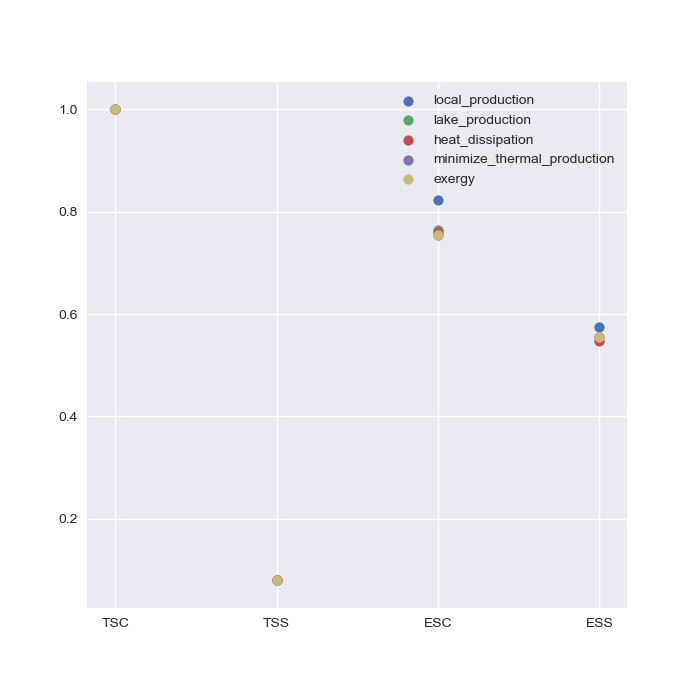

In [54]:
data_test = {'local_production': [collect_data['TSC'].values[0],
                                  collect_data['TSS'].values[0],
                                  collect_data['ESC'].values[0],
                                  collect_data['ESS'].values[0]],
             'lake_production': [collect_data['TSC'].values[1],
                                 collect_data['TSS'].values[1],
                                 collect_data['ESC'].values[1],
                                 collect_data['ESS'].values[1]],
             'heat_dissipation': [collect_data['TSC'].values[2],
                                  collect_data['TSS'].values[2],
                                  collect_data['ESC'].values[2],
                                  collect_data['ESS'].values[2]],
             'minimize_thermal_production': [collect_data['TSC'].values[3],
                                             collect_data['TSS'].values[3],
                                             collect_data['ESC'].values[3],
                                             collect_data['ESS'].values[
                                                 3]],
             'exergy': [collect_data['TSC'].values[4],
                        collect_data['TSS'].values[4],
                        collect_data['ESC'].values[4],
                        collect_data['ESS'].values[4]]}

fig, ax = plt.subplots(1, 1, figsize=(7, 6.75))

ax.scatter(['TSC', 'TSS', 'ESC', 'ESS'], data_test['local_production'])
ax.scatter(['TSC', 'TSS', 'ESC', 'ESS'], data_test['lake_production'])
ax.scatter(['TSC', 'TSS', 'ESC', 'ESS'], data_test['heat_dissipation'])
ax.scatter(['TSC', 'TSS', 'ESC', 'ESS'],
           data_test['minimize_thermal_production'])
ax.scatter(['TSC', 'TSS', 'ESC', 'ESS'], data_test['exergy'])

ax.legend(['local_production', 'lake_production', 'heat_dissipation',
           'minimize_thermal_production', 'exergy'])

plt.show()


From this line you can restart the process by changing the input data.

Once you have got enough data, please uncomment the following script in order to load the csv file in your folder.

### Save a CSV file <a class="anchor" id="chapter33"></a>

In [55]:
# collect_data.to_csv(csv_path + csv_name)

## General conclusion <a class="anchor" id="chapter4"></a>


Discussion of the problem/use case and perspectives